# Afriat

In [1]:
ood_seed = 2

In [2]:
num_ood = 1  # not functioning

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0.0', 'Pericentral', 'Control'),
  ('0.0', 'Periportal', 'Control'),
  ('12.0', 'Pericentral', 'Infected'),
  ('12.0', 'Pericentral', 'Uninfected'),
  ('12.0', 'Periportal', 'Infected'),
  ('12.0', 'Periportal', 'Uninfected'),
  ('2.0', 'Pericentral', 'Uninfected'),
  ('2.0', 'Periportal', 'Infected'),
  ('2.0', 'Periportal', 'Uninfected'),
  ('24.0', 'Pericentral', 'Infected'),
  ('24.0', 'Pericentral', 'Uninfected'),
  ('24.0', 'Periportal', 'Infected'),
  ('24.0', 'Periportal', 'Uninfected'),
  ('30.0', 'Pericentral', 'Infected'),
  ('30.0', 'Pericentral', 'Uninfected'),
  ('30.0', 'Periportal', 'Infected'),
  ('30.0', 'Periportal', 'Uninfected'),
  ('36.0', 'Pericentral', 'Infected'),
  ('36.0', 'Pericentral', 'Uninfected'),
  ('36.0', 'Periportal', 'Infected'),
  ('36.0', 'Periportal', 'Uninfected')],
 21)

In [7]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

('12.0', 'Pericentral', 'Infected')

Removed datapoint: 179


In [8]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "status_control",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "time_cat",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "zone",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [9]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates = False,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=None,
    model_level_metrics_helper_covariates=None
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: 000mkr1z
Name: forgotten-carrier-179
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/000mkr1z
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240504_212226-000mkr1z/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `training` set. Number of elements in each group: 2547,3130,9423
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `training` set. Number of elements in each group: 2547,2434,1702,3459,1610,3348
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 4339,10761
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `validation` set. Number of elements in each group: 658,800,2316
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `validation` set. Number of elements in each group: 658,589,406,831,439,851
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 1066,2708
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:13<2:14:52, 13.51s/it]

Epoch 1/600:   0%|          | 1/600 [00:13<2:14:52, 13.51s/it, v_num=1z_1, total_loss_train=3.7e+3, kl_local_train=53.4]

Epoch 2/600:   0%|          | 1/600 [00:13<2:14:52, 13.51s/it, v_num=1z_1, total_loss_train=3.7e+3, kl_local_train=53.4]

Epoch 2/600:   0%|          | 2/600 [00:25<2:06:59, 12.74s/it, v_num=1z_1, total_loss_train=3.7e+3, kl_local_train=53.4]

Epoch 2/600:   0%|          | 2/600 [00:25<2:06:59, 12.74s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=80.8]

Epoch 3/600:   0%|          | 2/600 [00:25<2:06:59, 12.74s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=80.8]

Epoch 3/600:   0%|          | 3/600 [00:37<2:04:02, 12.47s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=80.8]

Epoch 3/600:   0%|          | 3/600 [00:37<2:04:02, 12.47s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=82.6]

Epoch 4/600:   0%|          | 3/600 [00:37<2:04:02, 12.47s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=82.6]

Epoch 4/600:   1%|          | 4/600 [00:49<2:02:33, 12.34s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=82.6]

Epoch 4/600:   1%|          | 4/600 [00:49<2:02:33, 12.34s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=79.6]

Epoch 5/600:   1%|          | 4/600 [00:50<2:02:33, 12.34s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=79.6]

Epoch 5/600:   1%|          | 5/600 [01:02<2:01:43, 12.28s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=79.6]

Epoch 5/600:   1%|          | 5/600 [01:02<2:01:43, 12.28s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=73.3] 

Epoch 6/600:   1%|          | 5/600 [01:02<2:01:43, 12.28s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=73.3]

Epoch 6/600:   1%|          | 6/600 [01:14<2:00:59, 12.22s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=73.3]

Epoch 6/600:   1%|          | 6/600 [01:14<2:00:59, 12.22s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=63.1]

Epoch 7/600:   1%|          | 6/600 [01:14<2:00:59, 12.22s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=63.1]

Epoch 7/600:   1%|          | 7/600 [01:26<2:01:07, 12.26s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=63.1]

Epoch 7/600:   1%|          | 7/600 [01:26<2:01:07, 12.26s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=45.2]

Epoch 8/600:   1%|          | 7/600 [01:26<2:01:07, 12.26s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=45.2]

Epoch 8/600:   1%|▏         | 8/600 [01:38<2:00:45, 12.24s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=45.2]

Epoch 8/600:   1%|▏         | 8/600 [01:38<2:00:45, 12.24s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=37.7]

Epoch 9/600:   1%|▏         | 8/600 [01:38<2:00:45, 12.24s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=37.7]

Epoch 9/600:   2%|▏         | 9/600 [01:51<2:00:29, 12.23s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=37.7]

Epoch 9/600:   2%|▏         | 9/600 [01:51<2:00:29, 12.23s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=46.8]

Epoch 10/600:   2%|▏         | 9/600 [01:51<2:00:29, 12.23s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=46.8]

Epoch 10/600:   2%|▏         | 10/600 [02:03<2:00:09, 12.22s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=46.8]

Epoch 10/600:   2%|▏         | 10/600 [02:03<2:00:09, 12.22s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=95.2]

Epoch 11/600:   2%|▏         | 10/600 [02:03<2:00:09, 12.22s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=95.2]

Epoch 11/600:   2%|▏         | 11/600 [02:15<1:59:51, 12.21s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=95.2]

Epoch 11/600:   2%|▏         | 11/600 [02:15<1:59:51, 12.21s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=153] 

Epoch 12/600:   2%|▏         | 11/600 [02:15<1:59:51, 12.21s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=153]

Epoch 12/600:   2%|▏         | 12/600 [02:27<1:59:50, 12.23s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=153]

Epoch 12/600:   2%|▏         | 12/600 [02:27<1:59:50, 12.23s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=219] 

Epoch 13/600:   2%|▏         | 12/600 [02:27<1:59:50, 12.23s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=219]

Epoch 13/600:   2%|▏         | 13/600 [02:39<1:59:32, 12.22s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=219]

Epoch 13/600:   2%|▏         | 13/600 [02:39<1:59:32, 12.22s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=268]

Epoch 14/600:   2%|▏         | 13/600 [02:39<1:59:32, 12.22s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=268]

Epoch 14/600:   2%|▏         | 14/600 [02:52<1:59:29, 12.23s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=268]

Epoch 14/600:   2%|▏         | 14/600 [02:52<1:59:29, 12.23s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=305]

Epoch 15/600:   2%|▏         | 14/600 [02:52<1:59:29, 12.23s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=305]

Epoch 15/600:   2%|▎         | 15/600 [03:04<1:59:27, 12.25s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=305]

Epoch 15/600:   2%|▎         | 15/600 [03:04<1:59:27, 12.25s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=333]

Epoch 16/600:   2%|▎         | 15/600 [03:04<1:59:27, 12.25s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=333]

Epoch 16/600:   3%|▎         | 16/600 [03:16<1:59:17, 12.26s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=333]

Epoch 16/600:   3%|▎         | 16/600 [03:16<1:59:17, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=346]

Epoch 17/600:   3%|▎         | 16/600 [03:16<1:59:17, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=346]

Epoch 17/600:   3%|▎         | 17/600 [03:28<1:59:13, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=346]

Epoch 17/600:   3%|▎         | 17/600 [03:29<1:59:13, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=385]

Epoch 18/600:   3%|▎         | 17/600 [03:29<1:59:13, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=385]

Epoch 18/600:   3%|▎         | 18/600 [03:41<1:59:01, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=385]

Epoch 18/600:   3%|▎         | 18/600 [03:41<1:59:01, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=404]

Epoch 19/600:   3%|▎         | 18/600 [03:41<1:59:01, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=404]

Epoch 19/600:   3%|▎         | 19/600 [03:53<1:58:41, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=404]

Epoch 19/600:   3%|▎         | 19/600 [03:53<1:58:41, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=424]

Epoch 20/600:   3%|▎         | 19/600 [03:53<1:58:41, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=424]

Epoch 20/600:   3%|▎         | 20/600 [04:05<1:58:30, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=424]

Epoch 20/600:   3%|▎         | 20/600 [04:05<1:58:30, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=457]

Epoch 21/600:   3%|▎         | 20/600 [04:05<1:58:30, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=457]

Epoch 21/600:   4%|▎         | 21/600 [04:18<1:58:18, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=457]

Epoch 21/600:   4%|▎         | 21/600 [04:18<1:58:18, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=494]

Epoch 22/600:   4%|▎         | 21/600 [04:18<1:58:18, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=494]

Epoch 22/600:   4%|▎         | 22/600 [04:30<1:58:04, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=494]

Epoch 22/600:   4%|▎         | 22/600 [04:30<1:58:04, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=531]

Epoch 23/600:   4%|▎         | 22/600 [04:30<1:58:04, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=531]

Epoch 23/600:   4%|▍         | 23/600 [04:42<1:57:54, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=531]

Epoch 23/600:   4%|▍         | 23/600 [04:42<1:57:54, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=576]

Epoch 24/600:   4%|▍         | 23/600 [04:42<1:57:54, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=576]

Epoch 24/600:   4%|▍         | 24/600 [04:54<1:57:42, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=576]

Epoch 24/600:   4%|▍         | 24/600 [04:54<1:57:42, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=525]

Epoch 25/600:   4%|▍         | 24/600 [04:54<1:57:42, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=525]

Epoch 25/600:   4%|▍         | 25/600 [05:07<1:57:30, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=525]

Epoch 25/600:   4%|▍         | 25/600 [05:07<1:57:30, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=459]

Epoch 26/600:   4%|▍         | 25/600 [05:07<1:57:30, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=459]

Epoch 26/600:   4%|▍         | 26/600 [05:19<1:57:17, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=459]

Epoch 26/600:   4%|▍         | 26/600 [05:19<1:57:17, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=456]

Epoch 27/600:   4%|▍         | 26/600 [05:19<1:57:17, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=456]

Epoch 27/600:   4%|▍         | 27/600 [05:31<1:57:06, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=456]

Epoch 27/600:   4%|▍         | 27/600 [05:31<1:57:06, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=447]

Epoch 28/600:   4%|▍         | 27/600 [05:31<1:57:06, 12.26s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=447]

Epoch 28/600:   5%|▍         | 28/600 [05:43<1:57:00, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=447]

Epoch 28/600:   5%|▍         | 28/600 [05:43<1:57:00, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=416]

Epoch 29/600:   5%|▍         | 28/600 [05:43<1:57:00, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=416]

Epoch 29/600:   5%|▍         | 29/600 [05:56<1:56:51, 12.28s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=416]

Epoch 29/600:   5%|▍         | 29/600 [05:56<1:56:51, 12.28s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=417]

Epoch 30/600:   5%|▍         | 29/600 [05:56<1:56:51, 12.28s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=417]

Epoch 30/600:   5%|▌         | 30/600 [06:08<1:56:36, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=417]

Epoch 30/600:   5%|▌         | 30/600 [06:08<1:56:36, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=353]

Epoch 31/600:   5%|▌         | 30/600 [06:08<1:56:36, 12.27s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=353]

Epoch 31/600:   5%|▌         | 31/600 [06:20<1:56:04, 12.24s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=353]

Epoch 31/600:   5%|▌         | 31/600 [06:20<1:56:04, 12.24s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=315]

Epoch 32/600:   5%|▌         | 31/600 [06:20<1:56:04, 12.24s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=315]

Epoch 32/600:   5%|▌         | 32/600 [06:32<1:56:14, 12.28s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=315]

Epoch 32/600:   5%|▌         | 32/600 [06:32<1:56:14, 12.28s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=268]

Epoch 33/600:   5%|▌         | 32/600 [06:32<1:56:14, 12.28s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=268]

Epoch 33/600:   6%|▌         | 33/600 [06:45<1:56:10, 12.29s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=268]

Epoch 33/600:   6%|▌         | 33/600 [06:45<1:56:10, 12.29s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=249]

Epoch 34/600:   6%|▌         | 33/600 [06:45<1:56:10, 12.29s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=249]

Epoch 34/600:   6%|▌         | 34/600 [06:57<1:55:52, 12.28s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=249]

Epoch 34/600:   6%|▌         | 34/600 [06:57<1:55:52, 12.28s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=224]

Epoch 35/600:   6%|▌         | 34/600 [06:57<1:55:52, 12.28s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=224]

Epoch 35/600:   6%|▌         | 35/600 [07:09<1:55:52, 12.30s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=224]

Epoch 35/600:   6%|▌         | 35/600 [07:09<1:55:52, 12.30s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=217]

Epoch 36/600:   6%|▌         | 35/600 [07:09<1:55:52, 12.30s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=217]

Epoch 36/600:   6%|▌         | 36/600 [07:22<1:55:27, 12.28s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=217]

Epoch 36/600:   6%|▌         | 36/600 [07:22<1:55:27, 12.28s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=206]

Epoch 37/600:   6%|▌         | 36/600 [07:22<1:55:27, 12.28s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=206]

Epoch 37/600:   6%|▌         | 37/600 [07:34<1:54:58, 12.25s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=206]

Epoch 37/600:   6%|▌         | 37/600 [07:34<1:54:58, 12.25s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=195]

Epoch 38/600:   6%|▌         | 37/600 [07:34<1:54:58, 12.25s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=195]

Epoch 38/600:   6%|▋         | 38/600 [07:46<1:54:28, 12.22s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=195]

Epoch 38/600:   6%|▋         | 38/600 [07:46<1:54:28, 12.22s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=188]

Epoch 39/600:   6%|▋         | 38/600 [07:46<1:54:28, 12.22s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=188]

Epoch 39/600:   6%|▋         | 39/600 [07:58<1:54:19, 12.23s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=188]

Epoch 39/600:   6%|▋         | 39/600 [07:58<1:54:19, 12.23s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=184]

Epoch 40/600:   6%|▋         | 39/600 [07:58<1:54:19, 12.23s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=184]

Epoch 40/600:   7%|▋         | 40/600 [08:10<1:54:01, 12.22s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=184]

Epoch 40/600:   7%|▋         | 40/600 [08:10<1:54:01, 12.22s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=186]

Epoch 41/600:   7%|▋         | 40/600 [08:10<1:54:01, 12.22s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=186]

Epoch 41/600:   7%|▋         | 41/600 [08:23<1:53:42, 12.20s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=186]

Epoch 41/600:   7%|▋         | 41/600 [08:23<1:53:42, 12.20s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=186]

Epoch 42/600:   7%|▋         | 41/600 [08:23<1:53:42, 12.20s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=186]

Epoch 42/600:   7%|▋         | 42/600 [08:35<1:53:26, 12.20s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=186]

Epoch 42/600:   7%|▋         | 42/600 [08:35<1:53:26, 12.20s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=190]

Epoch 43/600:   7%|▋         | 42/600 [08:35<1:53:26, 12.20s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=190]

Epoch 43/600:   7%|▋         | 43/600 [08:47<1:53:01, 12.17s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=190]

Epoch 43/600:   7%|▋         | 43/600 [08:47<1:53:01, 12.17s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=194]

Epoch 44/600:   7%|▋         | 43/600 [08:47<1:53:01, 12.17s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=194]

Epoch 44/600:   7%|▋         | 44/600 [08:59<1:53:24, 12.24s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=194]

Epoch 44/600:   7%|▋         | 44/600 [08:59<1:53:24, 12.24s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=196]

Epoch 45/600:   7%|▋         | 44/600 [08:59<1:53:24, 12.24s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=196]

Epoch 45/600:   8%|▊         | 45/600 [09:11<1:52:57, 12.21s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=196]

Epoch 45/600:   8%|▊         | 45/600 [09:11<1:52:57, 12.21s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=203]

Epoch 46/600:   8%|▊         | 45/600 [09:11<1:52:57, 12.21s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=203]

Epoch 46/600:   8%|▊         | 46/600 [09:24<1:52:32, 12.19s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=203]

Epoch 46/600:   8%|▊         | 46/600 [09:24<1:52:32, 12.19s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 47/600:   8%|▊         | 46/600 [09:24<1:52:32, 12.19s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 47/600:   8%|▊         | 47/600 [09:36<1:52:16, 12.18s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 47/600:   8%|▊         | 47/600 [09:36<1:52:16, 12.18s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 48/600:   8%|▊         | 47/600 [09:36<1:52:16, 12.18s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 48/600:   8%|▊         | 48/600 [09:48<1:52:03, 12.18s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 48/600:   8%|▊         | 48/600 [09:48<1:52:03, 12.18s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=216]

Epoch 49/600:   8%|▊         | 48/600 [09:48<1:52:03, 12.18s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=216]

Epoch 49/600:   8%|▊         | 49/600 [10:01<1:54:15, 12.44s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=216]

Epoch 49/600:   8%|▊         | 49/600 [10:01<1:54:15, 12.44s/it, v_num=1z_1, total_loss_train=3.26e+3, kl_local_train=218]

Epoch 50/600:   8%|▊         | 49/600 [10:01<1:54:15, 12.44s/it, v_num=1z_1, total_loss_train=3.26e+3, kl_local_train=218]

Epoch 50/600:   8%|▊         | 50/600 [10:15<1:58:47, 12.96s/it, v_num=1z_1, total_loss_train=3.26e+3, kl_local_train=218]

Epoch 50/600:   8%|▊         | 50/600 [10:15<1:58:47, 12.96s/it, v_num=1z_1, total_loss_train=3.26e+3, kl_local_train=222]

Epoch 51/600:   8%|▊         | 50/600 [10:15<1:58:47, 12.96s/it, v_num=1z_1, total_loss_train=3.26e+3, kl_local_train=222]

Epoch 51/600:   8%|▊         | 51/600 [10:29<2:02:11, 13.35s/it, v_num=1z_1, total_loss_train=3.26e+3, kl_local_train=222]

Epoch 51/600:   8%|▊         | 51/600 [10:29<2:02:11, 13.35s/it, v_num=1z_1, total_loss_train=3.26e+3, kl_local_train=228]

Epoch 52/600:   8%|▊         | 51/600 [10:29<2:02:11, 13.35s/it, v_num=1z_1, total_loss_train=3.26e+3, kl_local_train=228]

Epoch 52/600:   9%|▊         | 52/600 [10:44<2:04:18, 13.61s/it, v_num=1z_1, total_loss_train=3.26e+3, kl_local_train=228]

Epoch 52/600:   9%|▊         | 52/600 [10:44<2:04:18, 13.61s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=222]

Epoch 53/600:   9%|▊         | 52/600 [10:44<2:04:18, 13.61s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=222]

Epoch 53/600:   9%|▉         | 53/600 [10:58<2:05:42, 13.79s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=222]

Epoch 53/600:   9%|▉         | 53/600 [10:58<2:05:42, 13.79s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=221]

Epoch 54/600:   9%|▉         | 53/600 [10:58<2:05:42, 13.79s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=221]

Epoch 54/600:   9%|▉         | 54/600 [11:12<2:06:30, 13.90s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=221]

Epoch 54/600:   9%|▉         | 54/600 [11:12<2:06:30, 13.90s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=223]

Epoch 55/600:   9%|▉         | 54/600 [11:12<2:06:30, 13.90s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=223]

Epoch 55/600:   9%|▉         | 55/600 [11:26<2:07:07, 13.99s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=223]

Epoch 55/600:   9%|▉         | 55/600 [11:26<2:07:07, 13.99s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=213]

Epoch 56/600:   9%|▉         | 55/600 [11:26<2:07:07, 13.99s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=213]

Epoch 56/600:   9%|▉         | 56/600 [11:40<2:07:31, 14.07s/it, v_num=1z_1, total_loss_train=3.25e+3, kl_local_train=213]

Epoch 56/600:   9%|▉         | 56/600 [11:40<2:07:31, 14.07s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=205]

Epoch 57/600:   9%|▉         | 56/600 [11:40<2:07:31, 14.07s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=205]

Epoch 57/600:  10%|▉         | 57/600 [11:55<2:07:44, 14.11s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=205]

Epoch 57/600:  10%|▉         | 57/600 [11:55<2:07:44, 14.11s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=204]

Epoch 58/600:  10%|▉         | 57/600 [11:55<2:07:44, 14.11s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=204]

Epoch 58/600:  10%|▉         | 58/600 [12:09<2:07:34, 14.12s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=204]

Epoch 58/600:  10%|▉         | 58/600 [12:09<2:07:34, 14.12s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=199]

Epoch 59/600:  10%|▉         | 58/600 [12:09<2:07:34, 14.12s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=199]

Epoch 59/600:  10%|▉         | 59/600 [12:23<2:07:34, 14.15s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=199]

Epoch 59/600:  10%|▉         | 59/600 [12:23<2:07:34, 14.15s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=194]

Epoch 60/600:  10%|▉         | 59/600 [12:23<2:07:34, 14.15s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=194]

Epoch 60/600:  10%|█         | 60/600 [12:37<2:07:21, 14.15s/it, v_num=1z_1, total_loss_train=3.24e+3, kl_local_train=194]

Epoch 60/600:  10%|█         | 60/600 [12:37<2:07:21, 14.15s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=191]

Epoch 61/600:  10%|█         | 60/600 [12:37<2:07:21, 14.15s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=191]

Epoch 61/600:  10%|█         | 61/600 [12:51<2:07:22, 14.18s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=191]

Epoch 61/600:  10%|█         | 61/600 [12:51<2:07:22, 14.18s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=182]

Epoch 62/600:  10%|█         | 61/600 [12:51<2:07:22, 14.18s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=182]

Epoch 62/600:  10%|█         | 62/600 [13:06<2:07:02, 14.17s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=182]

Epoch 62/600:  10%|█         | 62/600 [13:06<2:07:02, 14.17s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=179]

Epoch 63/600:  10%|█         | 62/600 [13:06<2:07:02, 14.17s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=179]

Epoch 63/600:  10%|█         | 63/600 [13:20<2:06:40, 14.15s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=179]

Epoch 63/600:  10%|█         | 63/600 [13:20<2:06:40, 14.15s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=176]

Epoch 64/600:  10%|█         | 63/600 [13:20<2:06:40, 14.15s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=176]

Epoch 64/600:  11%|█         | 64/600 [13:34<2:06:20, 14.14s/it, v_num=1z_1, total_loss_train=3.23e+3, kl_local_train=176]

Epoch 64/600:  11%|█         | 64/600 [13:34<2:06:20, 14.14s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=174]

Epoch 65/600:  11%|█         | 64/600 [13:34<2:06:20, 14.14s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=174]

Epoch 65/600:  11%|█         | 65/600 [13:48<2:06:03, 14.14s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=174]

Epoch 65/600:  11%|█         | 65/600 [13:48<2:06:03, 14.14s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=169]

Epoch 66/600:  11%|█         | 65/600 [13:48<2:06:03, 14.14s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=169]

Epoch 66/600:  11%|█         | 66/600 [14:02<2:06:05, 14.17s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=169]

Epoch 66/600:  11%|█         | 66/600 [14:02<2:06:05, 14.17s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=167]

Epoch 67/600:  11%|█         | 66/600 [14:02<2:06:05, 14.17s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=167]

Epoch 67/600:  11%|█         | 67/600 [14:16<2:05:56, 14.18s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=167]

Epoch 67/600:  11%|█         | 67/600 [14:16<2:05:56, 14.18s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=166]

Epoch 68/600:  11%|█         | 67/600 [14:16<2:05:56, 14.18s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=166]

Epoch 68/600:  11%|█▏        | 68/600 [14:30<2:05:30, 14.15s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=166]

Epoch 68/600:  11%|█▏        | 68/600 [14:30<2:05:30, 14.15s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=167]

Epoch 69/600:  11%|█▏        | 68/600 [14:30<2:05:30, 14.15s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=167]

Epoch 69/600:  12%|█▏        | 69/600 [14:45<2:05:19, 14.16s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=167]

Epoch 69/600:  12%|█▏        | 69/600 [14:45<2:05:19, 14.16s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=164]

Epoch 70/600:  12%|█▏        | 69/600 [14:45<2:05:19, 14.16s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=164]

Epoch 70/600:  12%|█▏        | 70/600 [14:59<2:05:02, 14.16s/it, v_num=1z_1, total_loss_train=3.22e+3, kl_local_train=164]

Epoch 70/600:  12%|█▏        | 70/600 [14:59<2:05:02, 14.16s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=163]

Epoch 71/600:  12%|█▏        | 70/600 [14:59<2:05:02, 14.16s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=163]

Epoch 71/600:  12%|█▏        | 71/600 [15:13<2:04:46, 14.15s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=163]

Epoch 71/600:  12%|█▏        | 71/600 [15:13<2:04:46, 14.15s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=162]

Epoch 72/600:  12%|█▏        | 71/600 [15:13<2:04:46, 14.15s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=162]

Epoch 72/600:  12%|█▏        | 72/600 [15:27<2:04:33, 14.15s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=162]

Epoch 72/600:  12%|█▏        | 72/600 [15:27<2:04:33, 14.15s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=160]

Epoch 73/600:  12%|█▏        | 72/600 [15:27<2:04:33, 14.15s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=160]

Epoch 73/600:  12%|█▏        | 73/600 [15:41<2:04:09, 14.14s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=160]

Epoch 73/600:  12%|█▏        | 73/600 [15:41<2:04:09, 14.14s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 74/600:  12%|█▏        | 73/600 [15:41<2:04:09, 14.14s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 74/600:  12%|█▏        | 74/600 [15:55<2:04:14, 14.17s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 74/600:  12%|█▏        | 74/600 [15:55<2:04:14, 14.17s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 75/600:  12%|█▏        | 74/600 [15:55<2:04:14, 14.17s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 75/600:  12%|█▎        | 75/600 [16:10<2:03:55, 14.16s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 75/600:  12%|█▎        | 75/600 [16:10<2:03:55, 14.16s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 76/600:  12%|█▎        | 75/600 [16:10<2:03:55, 14.16s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 76/600:  13%|█▎        | 76/600 [16:24<2:03:41, 14.16s/it, v_num=1z_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 76/600:  13%|█▎        | 76/600 [16:24<2:03:41, 14.16s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=156] 

Epoch 77/600:  13%|█▎        | 76/600 [16:24<2:03:41, 14.16s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=156]

Epoch 77/600:  13%|█▎        | 77/600 [16:38<2:03:25, 14.16s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=156]

Epoch 77/600:  13%|█▎        | 77/600 [16:38<2:03:25, 14.16s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=155]

Epoch 78/600:  13%|█▎        | 77/600 [16:38<2:03:25, 14.16s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=155]

Epoch 78/600:  13%|█▎        | 78/600 [16:52<2:03:16, 14.17s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=155]

Epoch 78/600:  13%|█▎        | 78/600 [16:52<2:03:16, 14.17s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=154]

Epoch 79/600:  13%|█▎        | 78/600 [16:52<2:03:16, 14.17s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=154]

Epoch 79/600:  13%|█▎        | 79/600 [17:06<2:03:01, 14.17s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=154]

Epoch 79/600:  13%|█▎        | 79/600 [17:06<2:03:01, 14.17s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=153]

Epoch 80/600:  13%|█▎        | 79/600 [17:06<2:03:01, 14.17s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=153]

Epoch 80/600:  13%|█▎        | 80/600 [17:20<2:02:46, 14.17s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=153]

Epoch 80/600:  13%|█▎        | 80/600 [17:20<2:02:46, 14.17s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=153]

Epoch 81/600:  13%|█▎        | 80/600 [17:20<2:02:46, 14.17s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=153]

Epoch 81/600:  14%|█▎        | 81/600 [17:35<2:02:23, 14.15s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=153]

Epoch 81/600:  14%|█▎        | 81/600 [17:35<2:02:23, 14.15s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=151]

Epoch 82/600:  14%|█▎        | 81/600 [17:35<2:02:23, 14.15s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=151]

Epoch 82/600:  14%|█▎        | 82/600 [17:49<2:02:00, 14.13s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=151]

Epoch 82/600:  14%|█▎        | 82/600 [17:49<2:02:00, 14.13s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 83/600:  14%|█▎        | 82/600 [17:49<2:02:00, 14.13s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 83/600:  14%|█▍        | 83/600 [18:03<2:01:46, 14.13s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 83/600:  14%|█▍        | 83/600 [18:03<2:01:46, 14.13s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=151]

Epoch 84/600:  14%|█▍        | 83/600 [18:03<2:01:46, 14.13s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=151]

Epoch 84/600:  14%|█▍        | 84/600 [18:17<2:01:22, 14.11s/it, v_num=1z_1, total_loss_train=3.2e+3, kl_local_train=151]

Epoch 84/600:  14%|█▍        | 84/600 [18:17<2:01:22, 14.11s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 85/600:  14%|█▍        | 84/600 [18:17<2:01:22, 14.11s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 85/600:  14%|█▍        | 85/600 [18:31<2:01:16, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 85/600:  14%|█▍        | 85/600 [18:31<2:01:16, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 86/600:  14%|█▍        | 85/600 [18:31<2:01:16, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 86/600:  14%|█▍        | 86/600 [18:45<2:00:58, 14.12s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 86/600:  14%|█▍        | 86/600 [18:45<2:00:58, 14.12s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 87/600:  14%|█▍        | 86/600 [18:45<2:00:58, 14.12s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 87/600:  14%|█▍        | 87/600 [18:59<2:00:51, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 87/600:  14%|█▍        | 87/600 [18:59<2:00:51, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=147]

Epoch 88/600:  14%|█▍        | 87/600 [18:59<2:00:51, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=147]

Epoch 88/600:  15%|█▍        | 88/600 [19:13<2:00:33, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=147]

Epoch 88/600:  15%|█▍        | 88/600 [19:13<2:00:33, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=147]

Epoch 89/600:  15%|█▍        | 88/600 [19:13<2:00:33, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=147]

Epoch 89/600:  15%|█▍        | 89/600 [19:28<2:00:28, 14.15s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=147]

Epoch 89/600:  15%|█▍        | 89/600 [19:28<2:00:28, 14.15s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=146]

Epoch 90/600:  15%|█▍        | 89/600 [19:28<2:00:28, 14.15s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=146]

Epoch 90/600:  15%|█▌        | 90/600 [19:42<2:00:07, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=146]

Epoch 90/600:  15%|█▌        | 90/600 [19:42<2:00:07, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=144]

Epoch 91/600:  15%|█▌        | 90/600 [19:42<2:00:07, 14.13s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=144]

Epoch 91/600:  15%|█▌        | 91/600 [19:56<2:00:03, 14.15s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=144]

Epoch 91/600:  15%|█▌        | 91/600 [19:56<2:00:03, 14.15s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=145]

Epoch 92/600:  15%|█▌        | 91/600 [19:56<2:00:03, 14.15s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=145]

Epoch 92/600:  15%|█▌        | 92/600 [20:10<1:59:57, 14.17s/it, v_num=1z_1, total_loss_train=3.19e+3, kl_local_train=145]

Epoch 92/600:  15%|█▌        | 92/600 [20:10<1:59:57, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 93/600:  15%|█▌        | 92/600 [20:10<1:59:57, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 93/600:  16%|█▌        | 93/600 [20:24<1:59:38, 14.16s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 93/600:  16%|█▌        | 93/600 [20:24<1:59:38, 14.16s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 94/600:  16%|█▌        | 93/600 [20:24<1:59:38, 14.16s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 94/600:  16%|█▌        | 94/600 [20:38<1:59:33, 14.18s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 94/600:  16%|█▌        | 94/600 [20:38<1:59:33, 14.18s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 95/600:  16%|█▌        | 94/600 [20:38<1:59:33, 14.18s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 95/600:  16%|█▌        | 95/600 [20:53<1:59:14, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 95/600:  16%|█▌        | 95/600 [20:53<1:59:14, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=142]

Epoch 96/600:  16%|█▌        | 95/600 [20:53<1:59:14, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=142]

Epoch 96/600:  16%|█▌        | 96/600 [21:07<1:59:01, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=142]

Epoch 96/600:  16%|█▌        | 96/600 [21:07<1:59:01, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 97/600:  16%|█▌        | 96/600 [21:07<1:59:01, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 97/600:  16%|█▌        | 97/600 [21:21<1:58:43, 14.16s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 97/600:  16%|█▌        | 97/600 [21:21<1:58:43, 14.16s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=141]

Epoch 98/600:  16%|█▌        | 97/600 [21:21<1:58:43, 14.16s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=141]

Epoch 98/600:  16%|█▋        | 98/600 [21:35<1:58:33, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=141]

Epoch 98/600:  16%|█▋        | 98/600 [21:35<1:58:33, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=141]

Epoch 99/600:  16%|█▋        | 98/600 [21:35<1:58:33, 14.17s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=141]

Epoch 99/600:  16%|█▋        | 99/600 [21:49<1:58:31, 14.19s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=141]

Epoch 99/600:  16%|█▋        | 99/600 [21:49<1:58:31, 14.19s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=140]

Epoch 100/600:  16%|█▋        | 99/600 [21:49<1:58:31, 14.19s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=140]

Epoch 100/600:  17%|█▋        | 100/600 [22:04<1:58:20, 14.20s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=140]

Epoch 100/600:  17%|█▋        | 100/600 [22:04<1:58:20, 14.20s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=138]

Epoch 101/600:  17%|█▋        | 100/600 [22:04<1:58:20, 14.20s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=138]

Epoch 101/600:  17%|█▋        | 101/600 [22:18<1:58:06, 14.20s/it, v_num=1z_1, total_loss_train=3.18e+3, kl_local_train=138]

Epoch 101/600:  17%|█▋        | 101/600 [22:18<1:58:06, 14.20s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 102/600:  17%|█▋        | 101/600 [22:18<1:58:06, 14.20s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 102/600:  17%|█▋        | 102/600 [22:32<1:57:46, 14.19s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 102/600:  17%|█▋        | 102/600 [22:32<1:57:46, 14.19s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=138]

Epoch 103/600:  17%|█▋        | 102/600 [22:32<1:57:46, 14.19s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=138]

Epoch 103/600:  17%|█▋        | 103/600 [22:46<1:57:42, 14.21s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=138]

Epoch 103/600:  17%|█▋        | 103/600 [22:46<1:57:42, 14.21s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 104/600:  17%|█▋        | 103/600 [22:46<1:57:42, 14.21s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 104/600:  17%|█▋        | 104/600 [23:00<1:57:13, 14.18s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=139]

Epoch 104/600:  17%|█▋        | 104/600 [23:00<1:57:13, 14.18s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 105/600:  17%|█▋        | 104/600 [23:00<1:57:13, 14.18s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 105/600:  18%|█▊        | 105/600 [23:14<1:56:43, 14.15s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 105/600:  18%|█▊        | 105/600 [23:14<1:56:43, 14.15s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 106/600:  18%|█▊        | 105/600 [23:14<1:56:43, 14.15s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 106/600:  18%|█▊        | 106/600 [23:28<1:56:24, 14.14s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 106/600:  18%|█▊        | 106/600 [23:28<1:56:24, 14.14s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=136]

Epoch 107/600:  18%|█▊        | 106/600 [23:28<1:56:24, 14.14s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=136]

Epoch 107/600:  18%|█▊        | 107/600 [23:43<1:56:19, 14.16s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=136]

Epoch 107/600:  18%|█▊        | 107/600 [23:43<1:56:19, 14.16s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 108/600:  18%|█▊        | 107/600 [23:43<1:56:19, 14.16s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 108/600:  18%|█▊        | 108/600 [23:57<1:56:07, 14.16s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 108/600:  18%|█▊        | 108/600 [23:57<1:56:07, 14.16s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=135]

Epoch 109/600:  18%|█▊        | 108/600 [23:57<1:56:07, 14.16s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=135]

Epoch 109/600:  18%|█▊        | 109/600 [24:11<1:55:53, 14.16s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=135]

Epoch 109/600:  18%|█▊        | 109/600 [24:11<1:55:53, 14.16s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 110/600:  18%|█▊        | 109/600 [24:11<1:55:53, 14.16s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 110/600:  18%|█▊        | 110/600 [24:25<1:55:56, 14.20s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 110/600:  18%|█▊        | 110/600 [24:25<1:55:56, 14.20s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=133]

Epoch 111/600:  18%|█▊        | 110/600 [24:25<1:55:56, 14.20s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=133]

Epoch 111/600:  18%|█▊        | 111/600 [24:39<1:55:32, 14.18s/it, v_num=1z_1, total_loss_train=3.17e+3, kl_local_train=133]

Epoch 111/600:  18%|█▊        | 111/600 [24:39<1:55:32, 14.18s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 112/600:  18%|█▊        | 111/600 [24:39<1:55:32, 14.18s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 112/600:  19%|█▊        | 112/600 [24:54<1:55:23, 14.19s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 112/600:  19%|█▊        | 112/600 [24:54<1:55:23, 14.19s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 113/600:  19%|█▊        | 112/600 [24:54<1:55:23, 14.19s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 113/600:  19%|█▉        | 113/600 [25:08<1:55:13, 14.20s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=132]

Epoch 113/600:  19%|█▉        | 113/600 [25:08<1:55:13, 14.20s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 114/600:  19%|█▉        | 113/600 [25:08<1:55:13, 14.20s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 114/600:  19%|█▉        | 114/600 [25:22<1:54:59, 14.20s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 114/600:  19%|█▉        | 114/600 [25:22<1:54:59, 14.20s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 115/600:  19%|█▉        | 114/600 [25:22<1:54:59, 14.20s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 115/600:  19%|█▉        | 115/600 [25:36<1:54:34, 14.17s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 115/600:  19%|█▉        | 115/600 [25:36<1:54:34, 14.17s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 116/600:  19%|█▉        | 115/600 [25:36<1:54:34, 14.17s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 116/600:  19%|█▉        | 116/600 [25:50<1:54:12, 14.16s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 116/600:  19%|█▉        | 116/600 [25:50<1:54:12, 14.16s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 117/600:  19%|█▉        | 116/600 [25:50<1:54:12, 14.16s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 117/600:  20%|█▉        | 117/600 [26:04<1:53:51, 14.14s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 117/600:  20%|█▉        | 117/600 [26:04<1:53:51, 14.14s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=128]

Epoch 118/600:  20%|█▉        | 117/600 [26:04<1:53:51, 14.14s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=128]

Epoch 118/600:  20%|█▉        | 118/600 [26:19<1:53:37, 14.14s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=128]

Epoch 118/600:  20%|█▉        | 118/600 [26:19<1:53:37, 14.14s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=128]

Epoch 119/600:  20%|█▉        | 118/600 [26:19<1:53:37, 14.14s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=128]

Epoch 119/600:  20%|█▉        | 119/600 [26:33<1:53:27, 14.15s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=128]

Epoch 119/600:  20%|█▉        | 119/600 [26:33<1:53:27, 14.15s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 120/600:  20%|█▉        | 119/600 [26:33<1:53:27, 14.15s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 120/600:  20%|██        | 120/600 [26:47<1:53:08, 14.14s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 120/600:  20%|██        | 120/600 [26:47<1:53:08, 14.14s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=129]

Epoch 121/600:  20%|██        | 120/600 [26:47<1:53:08, 14.14s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=129]

Epoch 121/600:  20%|██        | 121/600 [27:01<1:53:10, 14.18s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=129]

Epoch 121/600:  20%|██        | 121/600 [27:01<1:53:10, 14.18s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 122/600:  20%|██        | 121/600 [27:01<1:53:10, 14.18s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 122/600:  20%|██        | 122/600 [27:15<1:53:00, 14.19s/it, v_num=1z_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 122/600:  20%|██        | 122/600 [27:15<1:53:00, 14.19s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 123/600:  20%|██        | 122/600 [27:15<1:53:00, 14.19s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 123/600:  20%|██        | 123/600 [27:29<1:52:52, 14.20s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 123/600:  20%|██        | 123/600 [27:29<1:52:52, 14.20s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 124/600:  20%|██        | 123/600 [27:30<1:52:52, 14.20s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 124/600:  21%|██        | 124/600 [27:44<1:52:50, 14.22s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 124/600:  21%|██        | 124/600 [27:44<1:52:50, 14.22s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 125/600:  21%|██        | 124/600 [27:44<1:52:50, 14.22s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 125/600:  21%|██        | 125/600 [27:58<1:52:34, 14.22s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 125/600:  21%|██        | 125/600 [27:58<1:52:34, 14.22s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 126/600:  21%|██        | 125/600 [27:58<1:52:34, 14.22s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 126/600:  21%|██        | 126/600 [28:12<1:52:12, 14.20s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 126/600:  21%|██        | 126/600 [28:12<1:52:12, 14.20s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 127/600:  21%|██        | 126/600 [28:12<1:52:12, 14.20s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 127/600:  21%|██        | 127/600 [28:26<1:51:47, 14.18s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 127/600:  21%|██        | 127/600 [28:26<1:51:47, 14.18s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 128/600:  21%|██        | 127/600 [28:26<1:51:47, 14.18s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 128/600:  21%|██▏       | 128/600 [28:40<1:51:37, 14.19s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 128/600:  21%|██▏       | 128/600 [28:40<1:51:37, 14.19s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 129/600:  21%|██▏       | 128/600 [28:41<1:51:37, 14.19s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 129/600:  22%|██▏       | 129/600 [28:55<1:51:10, 14.16s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=125]

Epoch 129/600:  22%|██▏       | 129/600 [28:55<1:51:10, 14.16s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 130/600:  22%|██▏       | 129/600 [28:55<1:51:10, 14.16s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 130/600:  22%|██▏       | 130/600 [29:09<1:51:01, 14.17s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 130/600:  22%|██▏       | 130/600 [29:09<1:51:01, 14.17s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 131/600:  22%|██▏       | 130/600 [29:09<1:51:01, 14.17s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 131/600:  22%|██▏       | 131/600 [29:22<1:48:55, 13.93s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 131/600:  22%|██▏       | 131/600 [29:22<1:48:55, 13.93s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=123]

Epoch 132/600:  22%|██▏       | 131/600 [29:22<1:48:55, 13.93s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=123]

Epoch 132/600:  22%|██▏       | 132/600 [29:34<1:44:02, 13.34s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=123]

Epoch 132/600:  22%|██▏       | 132/600 [29:34<1:44:02, 13.34s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 133/600:  22%|██▏       | 132/600 [29:34<1:44:02, 13.34s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 133/600:  22%|██▏       | 133/600 [29:46<1:40:48, 12.95s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 133/600:  22%|██▏       | 133/600 [29:46<1:40:48, 12.95s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 134/600:  22%|██▏       | 133/600 [29:46<1:40:48, 12.95s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 134/600:  22%|██▏       | 134/600 [29:58<1:38:22, 12.67s/it, v_num=1z_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 134/600:  22%|██▏       | 134/600 [29:58<1:38:22, 12.67s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 135/600:  22%|██▏       | 134/600 [29:58<1:38:22, 12.67s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 135/600:  22%|██▎       | 135/600 [30:10<1:36:43, 12.48s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 135/600:  22%|██▎       | 135/600 [30:10<1:36:43, 12.48s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 136/600:  22%|██▎       | 135/600 [30:10<1:36:43, 12.48s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 136/600:  23%|██▎       | 136/600 [30:22<1:35:24, 12.34s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 136/600:  23%|██▎       | 136/600 [30:22<1:35:24, 12.34s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 137/600:  23%|██▎       | 136/600 [30:22<1:35:24, 12.34s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 137/600:  23%|██▎       | 137/600 [30:34<1:34:23, 12.23s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 137/600:  23%|██▎       | 137/600 [30:34<1:34:23, 12.23s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 138/600:  23%|██▎       | 137/600 [30:34<1:34:23, 12.23s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 138/600:  23%|██▎       | 138/600 [30:46<1:33:46, 12.18s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 138/600:  23%|██▎       | 138/600 [30:46<1:33:46, 12.18s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 139/600:  23%|██▎       | 138/600 [30:46<1:33:46, 12.18s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 139/600:  23%|██▎       | 139/600 [30:58<1:33:19, 12.15s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 139/600:  23%|██▎       | 139/600 [30:58<1:33:19, 12.15s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 140/600:  23%|██▎       | 139/600 [30:58<1:33:19, 12.15s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 140/600:  23%|██▎       | 140/600 [31:10<1:32:42, 12.09s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 140/600:  23%|██▎       | 140/600 [31:10<1:32:42, 12.09s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 141/600:  23%|██▎       | 140/600 [31:10<1:32:42, 12.09s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 141/600:  24%|██▎       | 141/600 [31:22<1:32:20, 12.07s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 141/600:  24%|██▎       | 141/600 [31:22<1:32:20, 12.07s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 142/600:  24%|██▎       | 141/600 [31:22<1:32:20, 12.07s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 142/600:  24%|██▎       | 142/600 [31:34<1:31:55, 12.04s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 142/600:  24%|██▎       | 142/600 [31:34<1:31:55, 12.04s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 143/600:  24%|██▎       | 142/600 [31:34<1:31:55, 12.04s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 143/600:  24%|██▍       | 143/600 [31:46<1:31:44, 12.04s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 143/600:  24%|██▍       | 143/600 [31:46<1:31:44, 12.04s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=119]

Epoch 144/600:  24%|██▍       | 143/600 [31:46<1:31:44, 12.04s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=119]

Epoch 144/600:  24%|██▍       | 144/600 [31:58<1:31:30, 12.04s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=119]

Epoch 144/600:  24%|██▍       | 144/600 [31:58<1:31:30, 12.04s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 145/600:  24%|██▍       | 144/600 [31:58<1:31:30, 12.04s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 145/600:  24%|██▍       | 145/600 [32:10<1:31:12, 12.03s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 145/600:  24%|██▍       | 145/600 [32:10<1:31:12, 12.03s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 146/600:  24%|██▍       | 145/600 [32:10<1:31:12, 12.03s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 146/600:  24%|██▍       | 146/600 [32:22<1:30:54, 12.01s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 146/600:  24%|██▍       | 146/600 [32:22<1:30:54, 12.01s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=116]

Epoch 147/600:  24%|██▍       | 146/600 [32:22<1:30:54, 12.01s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=116]

Epoch 147/600:  24%|██▍       | 147/600 [32:34<1:30:40, 12.01s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=116]

Epoch 147/600:  24%|██▍       | 147/600 [32:34<1:30:40, 12.01s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 148/600:  24%|██▍       | 147/600 [32:34<1:30:40, 12.01s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 148/600:  25%|██▍       | 148/600 [32:46<1:30:34, 12.02s/it, v_num=1z_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 148/600:  25%|██▍       | 148/600 [32:46<1:30:34, 12.02s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 149/600:  25%|██▍       | 148/600 [32:46<1:30:34, 12.02s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 149/600:  25%|██▍       | 149/600 [32:58<1:30:11, 12.00s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 149/600:  25%|██▍       | 149/600 [32:58<1:30:11, 12.00s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 150/600:  25%|██▍       | 149/600 [32:58<1:30:11, 12.00s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 150/600:  25%|██▌       | 150/600 [33:10<1:30:02, 12.01s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 150/600:  25%|██▌       | 150/600 [33:10<1:30:02, 12.01s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 151/600:  25%|██▌       | 150/600 [33:10<1:30:02, 12.01s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 151/600:  25%|██▌       | 151/600 [33:22<1:29:39, 11.98s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 151/600:  25%|██▌       | 151/600 [33:22<1:29:39, 11.98s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 152/600:  25%|██▌       | 151/600 [33:22<1:29:39, 11.98s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 152/600:  25%|██▌       | 152/600 [33:34<1:29:41, 12.01s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 152/600:  25%|██▌       | 152/600 [33:34<1:29:41, 12.01s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 153/600:  25%|██▌       | 152/600 [33:34<1:29:41, 12.01s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 153/600:  26%|██▌       | 153/600 [33:46<1:29:29, 12.01s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 153/600:  26%|██▌       | 153/600 [33:46<1:29:29, 12.01s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 154/600:  26%|██▌       | 153/600 [33:46<1:29:29, 12.01s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 154/600:  26%|██▌       | 154/600 [33:58<1:29:26, 12.03s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 154/600:  26%|██▌       | 154/600 [33:58<1:29:26, 12.03s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 155/600:  26%|██▌       | 154/600 [33:58<1:29:26, 12.03s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 155/600:  26%|██▌       | 155/600 [34:10<1:29:06, 12.02s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 155/600:  26%|██▌       | 155/600 [34:10<1:29:06, 12.02s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 156/600:  26%|██▌       | 155/600 [34:10<1:29:06, 12.02s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 156/600:  26%|██▌       | 156/600 [34:23<1:29:02, 12.03s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 156/600:  26%|██▌       | 156/600 [34:23<1:29:02, 12.03s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 157/600:  26%|██▌       | 156/600 [34:23<1:29:02, 12.03s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 157/600:  26%|██▌       | 157/600 [34:35<1:29:15, 12.09s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 157/600:  26%|██▌       | 157/600 [34:35<1:29:15, 12.09s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 158/600:  26%|██▌       | 157/600 [34:35<1:29:15, 12.09s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 158/600:  26%|██▋       | 158/600 [34:47<1:29:02, 12.09s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 158/600:  26%|██▋       | 158/600 [34:47<1:29:02, 12.09s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 159/600:  26%|██▋       | 158/600 [34:47<1:29:02, 12.09s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 159/600:  26%|██▋       | 159/600 [34:59<1:28:47, 12.08s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 159/600:  26%|██▋       | 159/600 [34:59<1:28:47, 12.08s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 160/600:  26%|██▋       | 159/600 [34:59<1:28:47, 12.08s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 160/600:  27%|██▋       | 160/600 [35:11<1:28:29, 12.07s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 160/600:  27%|██▋       | 160/600 [35:11<1:28:29, 12.07s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 161/600:  27%|██▋       | 160/600 [35:11<1:28:29, 12.07s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 161/600:  27%|██▋       | 161/600 [35:23<1:28:23, 12.08s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 161/600:  27%|██▋       | 161/600 [35:23<1:28:23, 12.08s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 162/600:  27%|██▋       | 161/600 [35:23<1:28:23, 12.08s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 162/600:  27%|██▋       | 162/600 [35:35<1:28:08, 12.07s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 162/600:  27%|██▋       | 162/600 [35:35<1:28:08, 12.07s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=111]

Epoch 163/600:  27%|██▋       | 162/600 [35:35<1:28:08, 12.07s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=111]

Epoch 163/600:  27%|██▋       | 163/600 [35:47<1:27:43, 12.04s/it, v_num=1z_1, total_loss_train=3.13e+3, kl_local_train=111]

Epoch 163/600:  27%|██▋       | 163/600 [35:47<1:27:43, 12.04s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 164/600:  27%|██▋       | 163/600 [35:47<1:27:43, 12.04s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 164/600:  27%|██▋       | 164/600 [35:59<1:27:25, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 164/600:  27%|██▋       | 164/600 [35:59<1:27:25, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 165/600:  27%|██▋       | 164/600 [35:59<1:27:25, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 165/600:  28%|██▊       | 165/600 [36:11<1:27:09, 12.02s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 165/600:  28%|██▊       | 165/600 [36:11<1:27:09, 12.02s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 166/600:  28%|██▊       | 165/600 [36:11<1:27:09, 12.02s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 166/600:  28%|██▊       | 166/600 [36:23<1:26:50, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 166/600:  28%|██▊       | 166/600 [36:23<1:26:50, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 167/600:  28%|██▊       | 166/600 [36:23<1:26:50, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 167/600:  28%|██▊       | 167/600 [36:35<1:26:44, 12.02s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 167/600:  28%|██▊       | 167/600 [36:35<1:26:44, 12.02s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 168/600:  28%|██▊       | 167/600 [36:35<1:26:44, 12.02s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 168/600:  28%|██▊       | 168/600 [36:47<1:26:37, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 168/600:  28%|██▊       | 168/600 [36:47<1:26:37, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 169/600:  28%|██▊       | 168/600 [36:47<1:26:37, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 169/600:  28%|██▊       | 169/600 [36:59<1:26:25, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 169/600:  28%|██▊       | 169/600 [36:59<1:26:25, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 170/600:  28%|██▊       | 169/600 [36:59<1:26:25, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 170/600:  28%|██▊       | 170/600 [37:11<1:26:14, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 170/600:  28%|██▊       | 170/600 [37:11<1:26:14, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 171/600:  28%|██▊       | 170/600 [37:11<1:26:14, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 171/600:  28%|██▊       | 171/600 [37:23<1:25:58, 12.02s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 171/600:  28%|██▊       | 171/600 [37:23<1:25:58, 12.02s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 172/600:  28%|██▊       | 171/600 [37:23<1:25:58, 12.02s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 172/600:  29%|██▊       | 172/600 [37:35<1:25:55, 12.04s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 172/600:  29%|██▊       | 172/600 [37:35<1:25:55, 12.04s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 173/600:  29%|██▊       | 172/600 [37:35<1:25:55, 12.04s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 173/600:  29%|██▉       | 173/600 [37:47<1:25:38, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 173/600:  29%|██▉       | 173/600 [37:47<1:25:38, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 174/600:  29%|██▉       | 173/600 [37:47<1:25:38, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 174/600:  29%|██▉       | 174/600 [37:59<1:25:29, 12.04s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 174/600:  29%|██▉       | 174/600 [37:59<1:25:29, 12.04s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 175/600:  29%|██▉       | 174/600 [37:59<1:25:29, 12.04s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 175/600:  29%|██▉       | 175/600 [38:11<1:25:12, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 175/600:  29%|██▉       | 175/600 [38:11<1:25:12, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 176/600:  29%|██▉       | 175/600 [38:11<1:25:12, 12.03s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 176/600:  29%|██▉       | 176/600 [38:23<1:24:51, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 176/600:  29%|██▉       | 176/600 [38:23<1:24:51, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 177/600:  29%|██▉       | 176/600 [38:23<1:24:51, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 177/600:  30%|██▉       | 177/600 [38:35<1:24:36, 12.00s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 177/600:  30%|██▉       | 177/600 [38:35<1:24:36, 12.00s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 178/600:  30%|██▉       | 177/600 [38:35<1:24:36, 12.00s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 178/600:  30%|██▉       | 178/600 [38:47<1:24:27, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 178/600:  30%|██▉       | 178/600 [38:47<1:24:27, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 179/600:  30%|██▉       | 178/600 [38:47<1:24:27, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 179/600:  30%|██▉       | 179/600 [38:59<1:24:08, 11.99s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 179/600:  30%|██▉       | 179/600 [38:59<1:24:08, 11.99s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 180/600:  30%|██▉       | 179/600 [38:59<1:24:08, 11.99s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 180/600:  30%|███       | 180/600 [39:11<1:24:02, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 180/600:  30%|███       | 180/600 [39:11<1:24:02, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 181/600:  30%|███       | 180/600 [39:11<1:24:02, 12.01s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 181/600:  30%|███       | 181/600 [39:23<1:23:48, 12.00s/it, v_num=1z_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 181/600:  30%|███       | 181/600 [39:23<1:23:48, 12.00s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 182/600:  30%|███       | 181/600 [39:23<1:23:48, 12.00s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 182/600:  30%|███       | 182/600 [39:35<1:23:46, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 182/600:  30%|███       | 182/600 [39:35<1:23:46, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 183/600:  30%|███       | 182/600 [39:35<1:23:46, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 183/600:  30%|███       | 183/600 [39:47<1:23:37, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 183/600:  30%|███       | 183/600 [39:47<1:23:37, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 184/600:  30%|███       | 183/600 [39:47<1:23:37, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 184/600:  31%|███       | 184/600 [39:59<1:23:21, 12.02s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 184/600:  31%|███       | 184/600 [39:59<1:23:21, 12.02s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 185/600:  31%|███       | 184/600 [39:59<1:23:21, 12.02s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 185/600:  31%|███       | 185/600 [40:11<1:23:02, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 185/600:  31%|███       | 185/600 [40:11<1:23:02, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 186/600:  31%|███       | 185/600 [40:11<1:23:02, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 186/600:  31%|███       | 186/600 [40:23<1:22:50, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 186/600:  31%|███       | 186/600 [40:23<1:22:50, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 187/600:  31%|███       | 186/600 [40:23<1:22:50, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 187/600:  31%|███       | 187/600 [40:35<1:22:43, 12.02s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 187/600:  31%|███       | 187/600 [40:35<1:22:43, 12.02s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 188/600:  31%|███       | 187/600 [40:36<1:22:43, 12.02s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 188/600:  31%|███▏      | 188/600 [40:47<1:22:29, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 188/600:  31%|███▏      | 188/600 [40:47<1:22:29, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 189/600:  31%|███▏      | 188/600 [40:48<1:22:29, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 189/600:  32%|███▏      | 189/600 [40:59<1:22:14, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 189/600:  32%|███▏      | 189/600 [40:59<1:22:14, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 190/600:  32%|███▏      | 189/600 [40:59<1:22:14, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 190/600:  32%|███▏      | 190/600 [41:12<1:22:05, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 190/600:  32%|███▏      | 190/600 [41:12<1:22:05, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 191/600:  32%|███▏      | 190/600 [41:12<1:22:05, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 191/600:  32%|███▏      | 191/600 [41:23<1:21:48, 12.00s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 191/600:  32%|███▏      | 191/600 [41:23<1:21:48, 12.00s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 192/600:  32%|███▏      | 191/600 [41:23<1:21:48, 12.00s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 192/600:  32%|███▏      | 192/600 [41:35<1:21:38, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 192/600:  32%|███▏      | 192/600 [41:36<1:21:38, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 193/600:  32%|███▏      | 192/600 [41:36<1:21:38, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 193/600:  32%|███▏      | 193/600 [41:48<1:21:29, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 193/600:  32%|███▏      | 193/600 [41:48<1:21:29, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 194/600:  32%|███▏      | 193/600 [41:48<1:21:29, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 194/600:  32%|███▏      | 194/600 [42:00<1:21:15, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 194/600:  32%|███▏      | 194/600 [42:00<1:21:15, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 195/600:  32%|███▏      | 194/600 [42:00<1:21:15, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 195/600:  32%|███▎      | 195/600 [42:12<1:21:04, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 195/600:  32%|███▎      | 195/600 [42:12<1:21:04, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 196/600:  32%|███▎      | 195/600 [42:12<1:21:04, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 196/600:  33%|███▎      | 196/600 [42:24<1:20:52, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 196/600:  33%|███▎      | 196/600 [42:24<1:20:52, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 197/600:  33%|███▎      | 196/600 [42:24<1:20:52, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 197/600:  33%|███▎      | 197/600 [42:36<1:20:37, 12.00s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 197/600:  33%|███▎      | 197/600 [42:36<1:20:37, 12.00s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 198/600:  33%|███▎      | 197/600 [42:36<1:20:37, 12.00s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 198/600:  33%|███▎      | 198/600 [42:48<1:20:29, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 198/600:  33%|███▎      | 198/600 [42:48<1:20:29, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 199/600:  33%|███▎      | 198/600 [42:48<1:20:29, 12.01s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 199/600:  33%|███▎      | 199/600 [43:00<1:20:24, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 199/600:  33%|███▎      | 199/600 [43:00<1:20:24, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 200/600:  33%|███▎      | 199/600 [43:00<1:20:24, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 200/600:  33%|███▎      | 200/600 [43:12<1:20:10, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 200/600:  33%|███▎      | 200/600 [43:12<1:20:10, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 201/600:  33%|███▎      | 200/600 [43:12<1:20:10, 12.03s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 201/600:  34%|███▎      | 201/600 [43:24<1:19:55, 12.02s/it, v_num=1z_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 201/600:  34%|███▎      | 201/600 [43:24<1:19:55, 12.02s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=103] 

Epoch 202/600:  34%|███▎      | 201/600 [43:24<1:19:55, 12.02s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 202/600:  34%|███▎      | 202/600 [43:36<1:19:46, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 202/600:  34%|███▎      | 202/600 [43:36<1:19:46, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 203/600:  34%|███▎      | 202/600 [43:36<1:19:46, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 203/600:  34%|███▍      | 203/600 [43:48<1:19:43, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 203/600:  34%|███▍      | 203/600 [43:48<1:19:43, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 204/600:  34%|███▍      | 203/600 [43:48<1:19:43, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 204/600:  34%|███▍      | 204/600 [44:00<1:19:34, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 204/600:  34%|███▍      | 204/600 [44:00<1:19:34, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 205/600:  34%|███▍      | 204/600 [44:00<1:19:34, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 205/600:  34%|███▍      | 205/600 [44:12<1:19:18, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 205/600:  34%|███▍      | 205/600 [44:12<1:19:18, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 206/600:  34%|███▍      | 205/600 [44:12<1:19:18, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 206/600:  34%|███▍      | 206/600 [44:24<1:19:00, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 206/600:  34%|███▍      | 206/600 [44:24<1:19:00, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 207/600:  34%|███▍      | 206/600 [44:24<1:19:00, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 207/600:  34%|███▍      | 207/600 [44:36<1:18:50, 12.04s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 207/600:  34%|███▍      | 207/600 [44:36<1:18:50, 12.04s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 208/600:  34%|███▍      | 207/600 [44:36<1:18:50, 12.04s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 208/600:  35%|███▍      | 208/600 [44:48<1:18:54, 12.08s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 208/600:  35%|███▍      | 208/600 [44:48<1:18:54, 12.08s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 209/600:  35%|███▍      | 208/600 [44:48<1:18:54, 12.08s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 209/600:  35%|███▍      | 209/600 [45:00<1:18:33, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 209/600:  35%|███▍      | 209/600 [45:00<1:18:33, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 210/600:  35%|███▍      | 209/600 [45:00<1:18:33, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 210/600:  35%|███▌      | 210/600 [45:12<1:18:24, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 210/600:  35%|███▌      | 210/600 [45:12<1:18:24, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 210/600 [45:12<1:18:24, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 211/600 [45:24<1:18:08, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 211/600 [45:24<1:18:08, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 212/600:  35%|███▌      | 211/600 [45:24<1:18:08, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 212/600:  35%|███▌      | 212/600 [45:36<1:18:01, 12.07s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 212/600:  35%|███▌      | 212/600 [45:36<1:18:01, 12.07s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 213/600:  35%|███▌      | 212/600 [45:36<1:18:01, 12.07s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 213/600:  36%|███▌      | 213/600 [45:48<1:17:37, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 213/600:  36%|███▌      | 213/600 [45:48<1:17:37, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 214/600:  36%|███▌      | 213/600 [45:48<1:17:37, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 214/600:  36%|███▌      | 214/600 [46:00<1:17:28, 12.04s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 214/600:  36%|███▌      | 214/600 [46:00<1:17:28, 12.04s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99.7]

Epoch 215/600:  36%|███▌      | 214/600 [46:00<1:17:28, 12.04s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99.7]

Epoch 215/600:  36%|███▌      | 215/600 [46:12<1:17:21, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99.7]

Epoch 215/600:  36%|███▌      | 215/600 [46:12<1:17:21, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99.7]

Epoch 216/600:  36%|███▌      | 215/600 [46:12<1:17:21, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99.7]

Epoch 216/600:  36%|███▌      | 216/600 [46:25<1:17:08, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99.7]

Epoch 216/600:  36%|███▌      | 216/600 [46:25<1:17:08, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99.4]

Epoch 217/600:  36%|███▌      | 216/600 [46:25<1:17:08, 12.05s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99.4]

Epoch 217/600:  36%|███▌      | 217/600 [46:37<1:16:59, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99.4]

Epoch 217/600:  36%|███▌      | 217/600 [46:37<1:16:59, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99]  

Epoch 218/600:  36%|███▌      | 217/600 [46:37<1:16:59, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99]

Epoch 218/600:  36%|███▋      | 218/600 [46:49<1:16:53, 12.08s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=99]

Epoch 218/600:  36%|███▋      | 218/600 [46:49<1:16:53, 12.08s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.7]

Epoch 219/600:  36%|███▋      | 218/600 [46:49<1:16:53, 12.08s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.7]

Epoch 219/600:  36%|███▋      | 219/600 [47:01<1:16:39, 12.07s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.7]

Epoch 219/600:  36%|███▋      | 219/600 [47:01<1:16:39, 12.07s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.3]

Epoch 220/600:  36%|███▋      | 219/600 [47:01<1:16:39, 12.07s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.3]

Epoch 220/600:  37%|███▋      | 220/600 [47:13<1:16:23, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.3]

Epoch 220/600:  37%|███▋      | 220/600 [47:13<1:16:23, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.4]

Epoch 221/600:  37%|███▋      | 220/600 [47:13<1:16:23, 12.06s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.4]

Epoch 221/600:  37%|███▋      | 221/600 [47:25<1:16:01, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.4]

Epoch 221/600:  37%|███▋      | 221/600 [47:25<1:16:01, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.7]

Epoch 222/600:  37%|███▋      | 221/600 [47:25<1:16:01, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.7]

Epoch 222/600:  37%|███▋      | 222/600 [47:37<1:15:47, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.7]

Epoch 222/600:  37%|███▋      | 222/600 [47:37<1:15:47, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.5]

Epoch 223/600:  37%|███▋      | 222/600 [47:37<1:15:47, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.5]

Epoch 223/600:  37%|███▋      | 223/600 [47:49<1:15:40, 12.04s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.5]

Epoch 223/600:  37%|███▋      | 223/600 [47:49<1:15:40, 12.04s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.1]

Epoch 224/600:  37%|███▋      | 223/600 [47:49<1:15:40, 12.04s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.1]

Epoch 224/600:  37%|███▋      | 224/600 [48:01<1:15:24, 12.03s/it, v_num=1z_1, total_loss_train=3.1e+3, kl_local_train=98.1]

Epoch 224/600:  37%|███▋      | 224/600 [48:01<1:15:24, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=97.3]

Epoch 225/600:  37%|███▋      | 224/600 [48:01<1:15:24, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=97.3]

Epoch 225/600:  38%|███▊      | 225/600 [48:13<1:15:15, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=97.3]

Epoch 225/600:  38%|███▊      | 225/600 [48:13<1:15:15, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=97.8]

Epoch 226/600:  38%|███▊      | 225/600 [48:13<1:15:15, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=97.8]

Epoch 226/600:  38%|███▊      | 226/600 [48:25<1:15:07, 12.05s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=97.8]

Epoch 226/600:  38%|███▊      | 226/600 [48:25<1:15:07, 12.05s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.9]

Epoch 227/600:  38%|███▊      | 226/600 [48:25<1:15:07, 12.05s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.9]

Epoch 227/600:  38%|███▊      | 227/600 [48:37<1:14:51, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.9]

Epoch 227/600:  38%|███▊      | 227/600 [48:37<1:14:51, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.9]

Epoch 228/600:  38%|███▊      | 227/600 [48:37<1:14:51, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.9]

Epoch 228/600:  38%|███▊      | 228/600 [48:49<1:14:40, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.9]

Epoch 228/600:  38%|███▊      | 228/600 [48:49<1:14:40, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.7]

Epoch 229/600:  38%|███▊      | 228/600 [48:49<1:14:40, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.7]

Epoch 229/600:  38%|███▊      | 229/600 [49:01<1:14:31, 12.05s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.7]

Epoch 229/600:  38%|███▊      | 229/600 [49:01<1:14:31, 12.05s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=97]  

Epoch 230/600:  38%|███▊      | 229/600 [49:01<1:14:31, 12.05s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=97]

Epoch 230/600:  38%|███▊      | 230/600 [49:13<1:14:23, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=97]

Epoch 230/600:  38%|███▊      | 230/600 [49:13<1:14:23, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.6]

Epoch 231/600:  38%|███▊      | 230/600 [49:13<1:14:23, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.6]

Epoch 231/600:  38%|███▊      | 231/600 [49:25<1:13:59, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.6]

Epoch 231/600:  38%|███▊      | 231/600 [49:25<1:13:59, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.5]

Epoch 232/600:  38%|███▊      | 231/600 [49:25<1:13:59, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.5]

Epoch 232/600:  39%|███▊      | 232/600 [49:37<1:13:51, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.5]

Epoch 232/600:  39%|███▊      | 232/600 [49:37<1:13:51, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.7]

Epoch 233/600:  39%|███▊      | 232/600 [49:37<1:13:51, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.7]

Epoch 233/600:  39%|███▉      | 233/600 [49:49<1:13:40, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.7]

Epoch 233/600:  39%|███▉      | 233/600 [49:49<1:13:40, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.2]

Epoch 234/600:  39%|███▉      | 233/600 [49:49<1:13:40, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.2]

Epoch 234/600:  39%|███▉      | 234/600 [50:01<1:13:42, 12.08s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.2]

Epoch 234/600:  39%|███▉      | 234/600 [50:01<1:13:42, 12.08s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.6]

Epoch 235/600:  39%|███▉      | 234/600 [50:01<1:13:42, 12.08s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.6]

Epoch 235/600:  39%|███▉      | 235/600 [50:14<1:13:25, 12.07s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.6]

Epoch 235/600:  39%|███▉      | 235/600 [50:14<1:13:25, 12.07s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.7]

Epoch 236/600:  39%|███▉      | 235/600 [50:14<1:13:25, 12.07s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.7]

Epoch 236/600:  39%|███▉      | 236/600 [50:26<1:13:06, 12.05s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96.7]

Epoch 236/600:  39%|███▉      | 236/600 [50:26<1:13:06, 12.05s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95.8]

Epoch 237/600:  39%|███▉      | 236/600 [50:26<1:13:06, 12.05s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95.8]

Epoch 237/600:  40%|███▉      | 237/600 [50:38<1:12:56, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95.8]

Epoch 237/600:  40%|███▉      | 237/600 [50:38<1:12:56, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95.7]

Epoch 238/600:  40%|███▉      | 237/600 [50:38<1:12:56, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95.7]

Epoch 238/600:  40%|███▉      | 238/600 [50:50<1:12:45, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95.7]

Epoch 238/600:  40%|███▉      | 238/600 [50:50<1:12:45, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96]  

Epoch 239/600:  40%|███▉      | 238/600 [50:50<1:12:45, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96]

Epoch 239/600:  40%|███▉      | 239/600 [51:02<1:12:34, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=96]

Epoch 239/600:  40%|███▉      | 239/600 [51:02<1:12:34, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.8]

Epoch 240/600:  40%|███▉      | 239/600 [51:02<1:12:34, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.8]

Epoch 240/600:  40%|████      | 240/600 [51:14<1:12:28, 12.08s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.8]

Epoch 240/600:  40%|████      | 240/600 [51:14<1:12:28, 12.08s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95.3]

Epoch 241/600:  40%|████      | 240/600 [51:14<1:12:28, 12.08s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95.3]

Epoch 241/600:  40%|████      | 241/600 [51:26<1:12:11, 12.07s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95.3]

Epoch 241/600:  40%|████      | 241/600 [51:26<1:12:11, 12.07s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95]  

Epoch 242/600:  40%|████      | 241/600 [51:26<1:12:11, 12.07s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95]

Epoch 242/600:  40%|████      | 242/600 [51:38<1:11:56, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95]

Epoch 242/600:  40%|████      | 242/600 [51:38<1:11:56, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95]

Epoch 243/600:  40%|████      | 242/600 [51:38<1:11:56, 12.06s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95]

Epoch 243/600:  40%|████      | 243/600 [51:50<1:11:39, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95]

Epoch 243/600:  40%|████      | 243/600 [51:50<1:11:39, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95]

Epoch 244/600:  40%|████      | 243/600 [51:50<1:11:39, 12.04s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95]

Epoch 244/600:  41%|████      | 244/600 [52:02<1:11:22, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=95]

Epoch 244/600:  41%|████      | 244/600 [52:02<1:11:22, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.3]

Epoch 245/600:  41%|████      | 244/600 [52:02<1:11:22, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.3]

Epoch 245/600:  41%|████      | 245/600 [52:14<1:11:09, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.3]

Epoch 245/600:  41%|████      | 245/600 [52:14<1:11:09, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.2]

Epoch 246/600:  41%|████      | 245/600 [52:14<1:11:09, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.2]

Epoch 246/600:  41%|████      | 246/600 [52:26<1:10:56, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.2]

Epoch 246/600:  41%|████      | 246/600 [52:26<1:10:56, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.9]

Epoch 247/600:  41%|████      | 246/600 [52:26<1:10:56, 12.03s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.9]

Epoch 247/600:  41%|████      | 247/600 [52:40<1:13:41, 12.53s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.9]

Epoch 247/600:  41%|████      | 247/600 [52:40<1:13:41, 12.53s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.7]

Epoch 248/600:  41%|████      | 247/600 [52:40<1:13:41, 12.53s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.7]

Epoch 248/600:  41%|████▏     | 248/600 [52:54<1:16:13, 12.99s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=94.7]

Epoch 248/600:  41%|████▏     | 248/600 [52:54<1:16:13, 12.99s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.9]

Epoch 249/600:  41%|████▏     | 248/600 [52:54<1:16:13, 12.99s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.9]

Epoch 249/600:  42%|████▏     | 249/600 [53:08<1:17:58, 13.33s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.9]

Epoch 249/600:  42%|████▏     | 249/600 [53:08<1:17:58, 13.33s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.5]

Epoch 250/600:  42%|████▏     | 249/600 [53:08<1:17:58, 13.33s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.5]

Epoch 250/600:  42%|████▏     | 250/600 [53:22<1:19:02, 13.55s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.5]

Epoch 250/600:  42%|████▏     | 250/600 [53:22<1:19:02, 13.55s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.6]

Epoch 251/600:  42%|████▏     | 250/600 [53:22<1:19:02, 13.55s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.6]

Epoch 251/600:  42%|████▏     | 251/600 [53:36<1:19:40, 13.70s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.6]

Epoch 251/600:  42%|████▏     | 251/600 [53:36<1:19:40, 13.70s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 252/600:  42%|████▏     | 251/600 [53:36<1:19:40, 13.70s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 252/600:  42%|████▏     | 252/600 [53:50<1:20:06, 13.81s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 252/600:  42%|████▏     | 252/600 [53:50<1:20:06, 13.81s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.5]

Epoch 253/600:  42%|████▏     | 252/600 [53:50<1:20:06, 13.81s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.5]

Epoch 253/600:  42%|████▏     | 253/600 [54:04<1:20:25, 13.91s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.5]

Epoch 253/600:  42%|████▏     | 253/600 [54:04<1:20:25, 13.91s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 254/600:  42%|████▏     | 253/600 [54:04<1:20:25, 13.91s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 254/600:  42%|████▏     | 254/600 [54:18<1:20:24, 13.94s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 254/600:  42%|████▏     | 254/600 [54:18<1:20:24, 13.94s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=92.9]

Epoch 255/600:  42%|████▏     | 254/600 [54:18<1:20:24, 13.94s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=92.9]

Epoch 255/600:  42%|████▎     | 255/600 [54:32<1:20:24, 13.99s/it, v_num=1z_1, total_loss_train=3.09e+3, kl_local_train=92.9]

Epoch 255/600:  42%|████▎     | 255/600 [54:32<1:20:24, 13.99s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.9]

Epoch 256/600:  42%|████▎     | 255/600 [54:32<1:20:24, 13.99s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.9]

Epoch 256/600:  43%|████▎     | 256/600 [54:46<1:20:29, 14.04s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.9]

Epoch 256/600:  43%|████▎     | 256/600 [54:46<1:20:29, 14.04s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.9]

Epoch 257/600:  43%|████▎     | 256/600 [54:46<1:20:29, 14.04s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.9]

Epoch 257/600:  43%|████▎     | 257/600 [55:00<1:20:12, 14.03s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.9]

Epoch 257/600:  43%|████▎     | 257/600 [55:00<1:20:12, 14.03s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 258/600:  43%|████▎     | 257/600 [55:00<1:20:12, 14.03s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 258/600:  43%|████▎     | 258/600 [55:15<1:20:03, 14.05s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 258/600:  43%|████▎     | 258/600 [55:15<1:20:03, 14.05s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 259/600:  43%|████▎     | 258/600 [55:15<1:20:03, 14.05s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 259/600:  43%|████▎     | 259/600 [55:29<1:19:49, 14.05s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 259/600:  43%|████▎     | 259/600 [55:29<1:19:49, 14.05s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.5]

Epoch 260/600:  43%|████▎     | 259/600 [55:29<1:19:49, 14.05s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.5]

Epoch 260/600:  43%|████▎     | 260/600 [55:43<1:19:41, 14.06s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.5]

Epoch 260/600:  43%|████▎     | 260/600 [55:43<1:19:41, 14.06s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.6]

Epoch 261/600:  43%|████▎     | 260/600 [55:43<1:19:41, 14.06s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.6]

Epoch 261/600:  44%|████▎     | 261/600 [55:57<1:19:32, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.6]

Epoch 261/600:  44%|████▎     | 261/600 [55:57<1:19:32, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.1]

Epoch 262/600:  44%|████▎     | 261/600 [55:57<1:19:32, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.1]

Epoch 262/600:  44%|████▎     | 262/600 [56:11<1:19:21, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=92.1]

Epoch 262/600:  44%|████▎     | 262/600 [56:11<1:19:21, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.4]

Epoch 263/600:  44%|████▎     | 262/600 [56:11<1:19:21, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.4]

Epoch 263/600:  44%|████▍     | 263/600 [56:25<1:19:11, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.4]

Epoch 263/600:  44%|████▍     | 263/600 [56:25<1:19:11, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 264/600:  44%|████▍     | 263/600 [56:25<1:19:11, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 264/600:  44%|████▍     | 264/600 [56:39<1:18:46, 14.07s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 264/600:  44%|████▍     | 264/600 [56:39<1:18:46, 14.07s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.7]

Epoch 265/600:  44%|████▍     | 264/600 [56:39<1:18:46, 14.07s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.7]

Epoch 265/600:  44%|████▍     | 265/600 [56:53<1:18:42, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.7]

Epoch 265/600:  44%|████▍     | 265/600 [56:53<1:18:42, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.2]

Epoch 266/600:  44%|████▍     | 265/600 [56:53<1:18:42, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.2]

Epoch 266/600:  44%|████▍     | 266/600 [57:07<1:18:23, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.2]

Epoch 266/600:  44%|████▍     | 266/600 [57:07<1:18:23, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.8]

Epoch 267/600:  44%|████▍     | 266/600 [57:07<1:18:23, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.8]

Epoch 267/600:  44%|████▍     | 267/600 [57:21<1:18:18, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.8]

Epoch 267/600:  44%|████▍     | 267/600 [57:21<1:18:18, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 268/600:  44%|████▍     | 267/600 [57:21<1:18:18, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 268/600:  45%|████▍     | 268/600 [57:36<1:18:06, 14.12s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 268/600:  45%|████▍     | 268/600 [57:36<1:18:06, 14.12s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.6]

Epoch 269/600:  45%|████▍     | 268/600 [57:36<1:18:06, 14.12s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.6]

Epoch 269/600:  45%|████▍     | 269/600 [57:50<1:17:54, 14.12s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.6]

Epoch 269/600:  45%|████▍     | 269/600 [57:50<1:17:54, 14.12s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.3]

Epoch 270/600:  45%|████▍     | 269/600 [57:50<1:17:54, 14.12s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.3]

Epoch 270/600:  45%|████▌     | 270/600 [58:04<1:17:35, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.3]

Epoch 270/600:  45%|████▌     | 270/600 [58:04<1:17:35, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.5]

Epoch 271/600:  45%|████▌     | 270/600 [58:04<1:17:35, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.5]

Epoch 271/600:  45%|████▌     | 271/600 [58:18<1:17:21, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.5]

Epoch 271/600:  45%|████▌     | 271/600 [58:18<1:17:21, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.9]

Epoch 272/600:  45%|████▌     | 271/600 [58:18<1:17:21, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.9]

Epoch 272/600:  45%|████▌     | 272/600 [58:32<1:17:05, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.9]

Epoch 272/600:  45%|████▌     | 272/600 [58:32<1:17:05, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.5]

Epoch 273/600:  45%|████▌     | 272/600 [58:32<1:17:05, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.5]

Epoch 273/600:  46%|████▌     | 273/600 [58:46<1:16:46, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.5]

Epoch 273/600:  46%|████▌     | 273/600 [58:46<1:16:46, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.4]

Epoch 274/600:  46%|████▌     | 273/600 [58:46<1:16:46, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.4]

Epoch 274/600:  46%|████▌     | 274/600 [59:00<1:16:30, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.4]

Epoch 274/600:  46%|████▌     | 274/600 [59:00<1:16:30, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.3]

Epoch 275/600:  46%|████▌     | 274/600 [59:00<1:16:30, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.3]

Epoch 275/600:  46%|████▌     | 275/600 [59:14<1:16:15, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.3]

Epoch 275/600:  46%|████▌     | 275/600 [59:14<1:16:15, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.4]

Epoch 276/600:  46%|████▌     | 275/600 [59:14<1:16:15, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.4]

Epoch 276/600:  46%|████▌     | 276/600 [59:28<1:16:09, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90.4]

Epoch 276/600:  46%|████▌     | 276/600 [59:28<1:16:09, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 277/600:  46%|████▌     | 276/600 [59:28<1:16:09, 14.10s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 277/600:  46%|████▌     | 277/600 [59:42<1:15:57, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 277/600:  46%|████▌     | 277/600 [59:42<1:15:57, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90]  

Epoch 278/600:  46%|████▌     | 277/600 [59:42<1:15:57, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90]

Epoch 278/600:  46%|████▋     | 278/600 [59:56<1:15:38, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=90]

Epoch 278/600:  46%|████▋     | 278/600 [59:57<1:15:38, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 279/600:  46%|████▋     | 278/600 [59:57<1:15:38, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 279/600:  46%|████▋     | 279/600 [1:00:11<1:15:33, 14.12s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 279/600:  46%|████▋     | 279/600 [1:00:11<1:15:33, 14.12s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.4]

Epoch 280/600:  46%|████▋     | 279/600 [1:00:11<1:15:33, 14.12s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.4]

Epoch 280/600:  47%|████▋     | 280/600 [1:00:25<1:15:14, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.4]

Epoch 280/600:  47%|████▋     | 280/600 [1:00:25<1:15:14, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.5]

Epoch 281/600:  47%|████▋     | 280/600 [1:00:25<1:15:14, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.5]

Epoch 281/600:  47%|████▋     | 281/600 [1:00:39<1:15:01, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.5]

Epoch 281/600:  47%|████▋     | 281/600 [1:00:39<1:15:01, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.6]

Epoch 282/600:  47%|████▋     | 281/600 [1:00:39<1:15:01, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.6]

Epoch 282/600:  47%|████▋     | 282/600 [1:00:53<1:14:45, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89.6]

Epoch 282/600:  47%|████▋     | 282/600 [1:00:53<1:14:45, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.8]

Epoch 283/600:  47%|████▋     | 282/600 [1:00:53<1:14:45, 14.11s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.8]

Epoch 283/600:  47%|████▋     | 283/600 [1:01:07<1:14:24, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.8]

Epoch 283/600:  47%|████▋     | 283/600 [1:01:07<1:14:24, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 284/600:  47%|████▋     | 283/600 [1:01:07<1:14:24, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 284/600:  47%|████▋     | 284/600 [1:01:21<1:14:10, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 284/600:  47%|████▋     | 284/600 [1:01:21<1:14:10, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.9]

Epoch 285/600:  47%|████▋     | 284/600 [1:01:21<1:14:10, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.9]

Epoch 285/600:  48%|████▊     | 285/600 [1:01:35<1:13:53, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.9]

Epoch 285/600:  48%|████▊     | 285/600 [1:01:35<1:13:53, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.5]

Epoch 286/600:  48%|████▊     | 285/600 [1:01:35<1:13:53, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.5]

Epoch 286/600:  48%|████▊     | 286/600 [1:01:49<1:13:37, 14.07s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.5]

Epoch 286/600:  48%|████▊     | 286/600 [1:01:49<1:13:37, 14.07s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 287/600:  48%|████▊     | 286/600 [1:01:49<1:13:37, 14.07s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 287/600:  48%|████▊     | 287/600 [1:02:03<1:13:30, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 287/600:  48%|████▊     | 287/600 [1:02:03<1:13:30, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89]  

Epoch 288/600:  48%|████▊     | 287/600 [1:02:03<1:13:30, 14.09s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89]

Epoch 288/600:  48%|████▊     | 288/600 [1:02:17<1:13:12, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=89]

Epoch 288/600:  48%|████▊     | 288/600 [1:02:17<1:13:12, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.4]

Epoch 289/600:  48%|████▊     | 288/600 [1:02:17<1:13:12, 14.08s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.4]

Epoch 289/600:  48%|████▊     | 289/600 [1:02:31<1:12:55, 14.07s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.4]

Epoch 289/600:  48%|████▊     | 289/600 [1:02:31<1:12:55, 14.07s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.5]

Epoch 290/600:  48%|████▊     | 289/600 [1:02:31<1:12:55, 14.07s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.5]

Epoch 290/600:  48%|████▊     | 290/600 [1:02:45<1:12:36, 14.05s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88.5]

Epoch 290/600:  48%|████▊     | 290/600 [1:02:45<1:12:36, 14.05s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.8]

Epoch 291/600:  48%|████▊     | 290/600 [1:02:45<1:12:36, 14.05s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.8]

Epoch 291/600:  48%|████▊     | 291/600 [1:02:59<1:12:15, 14.03s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.8]

Epoch 291/600:  48%|████▊     | 291/600 [1:02:59<1:12:15, 14.03s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.9]

Epoch 292/600:  48%|████▊     | 291/600 [1:02:59<1:12:15, 14.03s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.9]

Epoch 292/600:  49%|████▊     | 292/600 [1:03:13<1:12:01, 14.03s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.9]

Epoch 292/600:  49%|████▊     | 292/600 [1:03:13<1:12:01, 14.03s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.5]

Epoch 293/600:  49%|████▊     | 292/600 [1:03:13<1:12:01, 14.03s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.5]

Epoch 293/600:  49%|████▉     | 293/600 [1:03:27<1:11:44, 14.02s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.5]

Epoch 293/600:  49%|████▉     | 293/600 [1:03:27<1:11:44, 14.02s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88]  

Epoch 294/600:  49%|████▉     | 293/600 [1:03:27<1:11:44, 14.02s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88]

Epoch 294/600:  49%|████▉     | 294/600 [1:03:41<1:11:26, 14.01s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88]

Epoch 294/600:  49%|████▉     | 294/600 [1:03:41<1:11:26, 14.01s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88]

Epoch 295/600:  49%|████▉     | 294/600 [1:03:41<1:11:26, 14.01s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88]

Epoch 295/600:  49%|████▉     | 295/600 [1:03:55<1:11:13, 14.01s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=88]

Epoch 295/600:  49%|████▉     | 295/600 [1:03:55<1:11:13, 14.01s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=86.9]

Epoch 296/600:  49%|████▉     | 295/600 [1:03:55<1:11:13, 14.01s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=86.9]

Epoch 296/600:  49%|████▉     | 296/600 [1:04:09<1:11:01, 14.02s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=86.9]

Epoch 296/600:  49%|████▉     | 296/600 [1:04:09<1:11:01, 14.02s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.1]

Epoch 297/600:  49%|████▉     | 296/600 [1:04:10<1:11:01, 14.02s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.1]

Epoch 297/600:  50%|████▉     | 297/600 [1:04:23<1:10:46, 14.01s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.1]

Epoch 297/600:  50%|████▉     | 297/600 [1:04:24<1:10:46, 14.01s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.8]

Epoch 298/600:  50%|████▉     | 297/600 [1:04:24<1:10:46, 14.01s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.8]

Epoch 298/600:  50%|████▉     | 298/600 [1:04:37<1:10:30, 14.01s/it, v_num=1z_1, total_loss_train=3.08e+3, kl_local_train=87.8]

Epoch 298/600:  50%|████▉     | 298/600 [1:04:37<1:10:30, 14.01s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.8]

Epoch 299/600:  50%|████▉     | 298/600 [1:04:38<1:10:30, 14.01s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.8]

Epoch 299/600:  50%|████▉     | 299/600 [1:04:52<1:10:17, 14.01s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.8]

Epoch 299/600:  50%|████▉     | 299/600 [1:04:52<1:10:17, 14.01s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=87.1]

Epoch 300/600:  50%|████▉     | 299/600 [1:04:52<1:10:17, 14.01s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=87.1]

Epoch 300/600:  50%|█████     | 300/600 [1:05:06<1:10:03, 14.01s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=87.1]

Epoch 300/600:  50%|█████     | 300/600 [1:05:06<1:10:03, 14.01s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=87.2]

Epoch 301/600:  50%|█████     | 300/600 [1:05:06<1:10:03, 14.01s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=87.2]

Epoch 301/600:  50%|█████     | 301/600 [1:05:20<1:10:04, 14.06s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=87.2]

Epoch 301/600:  50%|█████     | 301/600 [1:05:20<1:10:04, 14.06s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.7]

Epoch 302/600:  50%|█████     | 301/600 [1:05:20<1:10:04, 14.06s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.7]

Epoch 302/600:  50%|█████     | 302/600 [1:05:34<1:09:49, 14.06s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.7]

Epoch 302/600:  50%|█████     | 302/600 [1:05:34<1:09:49, 14.06s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.7]

Epoch 303/600:  50%|█████     | 302/600 [1:05:34<1:09:49, 14.06s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.7]

Epoch 303/600:  50%|█████     | 303/600 [1:05:48<1:09:48, 14.10s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.7]

Epoch 303/600:  50%|█████     | 303/600 [1:05:48<1:09:48, 14.10s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.5]

Epoch 304/600:  50%|█████     | 303/600 [1:05:48<1:09:48, 14.10s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.5]

Epoch 304/600:  51%|█████     | 304/600 [1:06:02<1:09:36, 14.11s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.5]

Epoch 304/600:  51%|█████     | 304/600 [1:06:02<1:09:36, 14.11s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=87]  

Epoch 305/600:  51%|█████     | 304/600 [1:06:02<1:09:36, 14.11s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=87]

Epoch 305/600:  51%|█████     | 305/600 [1:06:16<1:09:24, 14.12s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=87]

Epoch 305/600:  51%|█████     | 305/600 [1:06:16<1:09:24, 14.12s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.6]

Epoch 306/600:  51%|█████     | 305/600 [1:06:16<1:09:24, 14.12s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.6]

Epoch 306/600:  51%|█████     | 306/600 [1:06:30<1:09:12, 14.12s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.6]

Epoch 306/600:  51%|█████     | 306/600 [1:06:30<1:09:12, 14.12s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.4]

Epoch 307/600:  51%|█████     | 306/600 [1:06:30<1:09:12, 14.12s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.4]

Epoch 307/600:  51%|█████     | 307/600 [1:06:45<1:09:03, 14.14s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.4]

Epoch 307/600:  51%|█████     | 307/600 [1:06:45<1:09:03, 14.14s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.8]

Epoch 308/600:  51%|█████     | 307/600 [1:06:45<1:09:03, 14.14s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.8]

Epoch 308/600:  51%|█████▏    | 308/600 [1:06:59<1:08:42, 14.12s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.8]

Epoch 308/600:  51%|█████▏    | 308/600 [1:06:59<1:08:42, 14.12s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.3]

Epoch 309/600:  51%|█████▏    | 308/600 [1:06:59<1:08:42, 14.12s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.3]

Epoch 309/600:  52%|█████▏    | 309/600 [1:07:13<1:08:35, 14.14s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.3]

Epoch 309/600:  52%|█████▏    | 309/600 [1:07:13<1:08:35, 14.14s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.2]

Epoch 310/600:  52%|█████▏    | 309/600 [1:07:13<1:08:35, 14.14s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.2]

Epoch 310/600:  52%|█████▏    | 310/600 [1:07:27<1:08:22, 14.15s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.2]

Epoch 310/600:  52%|█████▏    | 310/600 [1:07:27<1:08:22, 14.15s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86]  

Epoch 311/600:  52%|█████▏    | 310/600 [1:07:27<1:08:22, 14.15s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86]

Epoch 311/600:  52%|█████▏    | 311/600 [1:07:41<1:08:05, 14.14s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86]

Epoch 311/600:  52%|█████▏    | 311/600 [1:07:41<1:08:05, 14.14s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.2]

Epoch 312/600:  52%|█████▏    | 311/600 [1:07:41<1:08:05, 14.14s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.2]

Epoch 312/600:  52%|█████▏    | 312/600 [1:07:56<1:09:05, 14.40s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86.2]

Epoch 312/600:  52%|█████▏    | 312/600 [1:07:56<1:09:05, 14.40s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.7]

Epoch 313/600:  52%|█████▏    | 312/600 [1:07:56<1:09:05, 14.40s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.7]

Epoch 313/600:  52%|█████▏    | 313/600 [1:08:12<1:10:58, 14.84s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.7]

Epoch 313/600:  52%|█████▏    | 313/600 [1:08:12<1:10:58, 14.84s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86]  

Epoch 314/600:  52%|█████▏    | 313/600 [1:08:12<1:10:58, 14.84s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86]

Epoch 314/600:  52%|█████▏    | 314/600 [1:08:28<1:11:59, 15.10s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=86]

Epoch 314/600:  52%|█████▏    | 314/600 [1:08:28<1:11:59, 15.10s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.5]

Epoch 315/600:  52%|█████▏    | 314/600 [1:08:28<1:11:59, 15.10s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.5]

Epoch 315/600:  52%|█████▎    | 315/600 [1:08:43<1:12:30, 15.26s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.5]

Epoch 315/600:  52%|█████▎    | 315/600 [1:08:43<1:12:30, 15.26s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.3]

Epoch 316/600:  52%|█████▎    | 315/600 [1:08:43<1:12:30, 15.26s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.3]

Epoch 316/600:  53%|█████▎    | 316/600 [1:08:59<1:12:49, 15.39s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.3]

Epoch 316/600:  53%|█████▎    | 316/600 [1:08:59<1:12:49, 15.39s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.4]

Epoch 317/600:  53%|█████▎    | 316/600 [1:08:59<1:12:49, 15.39s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.4]

Epoch 317/600:  53%|█████▎    | 317/600 [1:09:14<1:12:39, 15.40s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.4]

Epoch 317/600:  53%|█████▎    | 317/600 [1:09:14<1:12:39, 15.40s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.2]

Epoch 318/600:  53%|█████▎    | 317/600 [1:09:14<1:12:39, 15.40s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.2]

Epoch 318/600:  53%|█████▎    | 318/600 [1:09:30<1:12:58, 15.53s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.2]

Epoch 318/600:  53%|█████▎    | 318/600 [1:09:30<1:12:58, 15.53s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 319/600:  53%|█████▎    | 318/600 [1:09:30<1:12:58, 15.53s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 319/600:  53%|█████▎    | 319/600 [1:09:46<1:12:54, 15.57s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 319/600:  53%|█████▎    | 319/600 [1:09:46<1:12:54, 15.57s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85]  

Epoch 320/600:  53%|█████▎    | 319/600 [1:09:46<1:12:54, 15.57s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85]

Epoch 320/600:  53%|█████▎    | 320/600 [1:10:02<1:12:52, 15.62s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85]

Epoch 320/600:  53%|█████▎    | 320/600 [1:10:02<1:12:52, 15.62s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.3]

Epoch 321/600:  53%|█████▎    | 320/600 [1:10:02<1:12:52, 15.62s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.3]

Epoch 321/600:  54%|█████▎    | 321/600 [1:10:17<1:12:46, 15.65s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85.3]

Epoch 321/600:  54%|█████▎    | 321/600 [1:10:17<1:12:46, 15.65s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.9]

Epoch 322/600:  54%|█████▎    | 321/600 [1:10:17<1:12:46, 15.65s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.9]

Epoch 322/600:  54%|█████▎    | 322/600 [1:10:33<1:12:37, 15.67s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.9]

Epoch 322/600:  54%|█████▎    | 322/600 [1:10:33<1:12:37, 15.67s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85]  

Epoch 323/600:  54%|█████▎    | 322/600 [1:10:33<1:12:37, 15.67s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85]

Epoch 323/600:  54%|█████▍    | 323/600 [1:10:49<1:12:34, 15.72s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=85]

Epoch 323/600:  54%|█████▍    | 323/600 [1:10:49<1:12:34, 15.72s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.6]

Epoch 324/600:  54%|█████▍    | 323/600 [1:10:49<1:12:34, 15.72s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.6]

Epoch 324/600:  54%|█████▍    | 324/600 [1:11:05<1:12:27, 15.75s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.6]

Epoch 324/600:  54%|█████▍    | 324/600 [1:11:05<1:12:27, 15.75s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.6]

Epoch 325/600:  54%|█████▍    | 324/600 [1:11:05<1:12:27, 15.75s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.6]

Epoch 325/600:  54%|█████▍    | 325/600 [1:11:21<1:12:13, 15.76s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.6]

Epoch 325/600:  54%|█████▍    | 325/600 [1:11:21<1:12:13, 15.76s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 326/600:  54%|█████▍    | 325/600 [1:11:21<1:12:13, 15.76s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 326/600:  54%|█████▍    | 326/600 [1:11:36<1:12:03, 15.78s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 326/600:  54%|█████▍    | 326/600 [1:11:36<1:12:03, 15.78s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.2]

Epoch 327/600:  54%|█████▍    | 326/600 [1:11:36<1:12:03, 15.78s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.2]

Epoch 327/600:  55%|█████▍    | 327/600 [1:11:52<1:11:38, 15.74s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.2]

Epoch 327/600:  55%|█████▍    | 327/600 [1:11:52<1:11:38, 15.74s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.7]

Epoch 328/600:  55%|█████▍    | 327/600 [1:11:52<1:11:38, 15.74s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.7]

Epoch 328/600:  55%|█████▍    | 328/600 [1:12:07<1:10:59, 15.66s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.7]

Epoch 328/600:  55%|█████▍    | 328/600 [1:12:07<1:10:59, 15.66s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.2]

Epoch 329/600:  55%|█████▍    | 328/600 [1:12:07<1:10:59, 15.66s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.2]

Epoch 329/600:  55%|█████▍    | 329/600 [1:12:23<1:10:50, 15.69s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=84.2]

Epoch 329/600:  55%|█████▍    | 329/600 [1:12:23<1:10:50, 15.69s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.5]

Epoch 330/600:  55%|█████▍    | 329/600 [1:12:23<1:10:50, 15.69s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.5]

Epoch 330/600:  55%|█████▌    | 330/600 [1:12:39<1:10:42, 15.71s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.5]

Epoch 330/600:  55%|█████▌    | 330/600 [1:12:39<1:10:42, 15.71s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.8]

Epoch 331/600:  55%|█████▌    | 330/600 [1:12:39<1:10:42, 15.71s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.8]

Epoch 331/600:  55%|█████▌    | 331/600 [1:12:54<1:09:07, 15.42s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.8]

Epoch 331/600:  55%|█████▌    | 331/600 [1:12:54<1:09:07, 15.42s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 332/600:  55%|█████▌    | 331/600 [1:12:54<1:09:07, 15.42s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 332/600:  55%|█████▌    | 332/600 [1:13:07<1:06:31, 14.89s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 332/600:  55%|█████▌    | 332/600 [1:13:07<1:06:31, 14.89s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.6]

Epoch 333/600:  55%|█████▌    | 332/600 [1:13:07<1:06:31, 14.89s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.6]

Epoch 333/600:  56%|█████▌    | 333/600 [1:13:21<1:04:03, 14.40s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.6]

Epoch 333/600:  56%|█████▌    | 333/600 [1:13:21<1:04:03, 14.40s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.9]

Epoch 334/600:  56%|█████▌    | 333/600 [1:13:21<1:04:03, 14.40s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.9]

Epoch 334/600:  56%|█████▌    | 334/600 [1:13:34<1:02:42, 14.15s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.9]

Epoch 334/600:  56%|█████▌    | 334/600 [1:13:34<1:02:42, 14.15s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.5]

Epoch 335/600:  56%|█████▌    | 334/600 [1:13:34<1:02:42, 14.15s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.5]

Epoch 335/600:  56%|█████▌    | 335/600 [1:13:48<1:01:36, 13.95s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.5]

Epoch 335/600:  56%|█████▌    | 335/600 [1:13:48<1:01:36, 13.95s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83]  

Epoch 336/600:  56%|█████▌    | 335/600 [1:13:48<1:01:36, 13.95s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83]

Epoch 336/600:  56%|█████▌    | 336/600 [1:14:01<1:00:47, 13.82s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83]

Epoch 336/600:  56%|█████▌    | 336/600 [1:14:01<1:00:47, 13.82s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.4]

Epoch 337/600:  56%|█████▌    | 336/600 [1:14:01<1:00:47, 13.82s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.4]

Epoch 337/600:  56%|█████▌    | 337/600 [1:14:14<59:44, 13.63s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.4]  

Epoch 337/600:  56%|█████▌    | 337/600 [1:14:14<59:44, 13.63s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.8]

Epoch 338/600:  56%|█████▌    | 337/600 [1:14:14<59:44, 13.63s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.8]

Epoch 338/600:  56%|█████▋    | 338/600 [1:14:28<59:18, 13.58s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.8]

Epoch 338/600:  56%|█████▋    | 338/600 [1:14:28<59:18, 13.58s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.6]

Epoch 339/600:  56%|█████▋    | 338/600 [1:14:28<59:18, 13.58s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.6]

Epoch 339/600:  56%|█████▋    | 339/600 [1:14:41<59:02, 13.57s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.6]

Epoch 339/600:  56%|█████▋    | 339/600 [1:14:41<59:02, 13.57s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83]  

Epoch 340/600:  56%|█████▋    | 339/600 [1:14:41<59:02, 13.57s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83]

Epoch 340/600:  57%|█████▋    | 340/600 [1:14:55<58:38, 13.53s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83]

Epoch 340/600:  57%|█████▋    | 340/600 [1:14:55<58:38, 13.53s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.9]

Epoch 341/600:  57%|█████▋    | 340/600 [1:14:55<58:38, 13.53s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.9]

Epoch 341/600:  57%|█████▋    | 341/600 [1:15:08<58:19, 13.51s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.9]

Epoch 341/600:  57%|█████▋    | 341/600 [1:15:08<58:19, 13.51s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.2]

Epoch 342/600:  57%|█████▋    | 341/600 [1:15:08<58:19, 13.51s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.2]

Epoch 342/600:  57%|█████▋    | 342/600 [1:15:22<57:50, 13.45s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83.2]

Epoch 342/600:  57%|█████▋    | 342/600 [1:15:22<57:50, 13.45s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83]  

Epoch 343/600:  57%|█████▋    | 342/600 [1:15:22<57:50, 13.45s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83]

Epoch 343/600:  57%|█████▋    | 343/600 [1:15:35<57:44, 13.48s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=83]

Epoch 343/600:  57%|█████▋    | 343/600 [1:15:35<57:44, 13.48s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82]

Epoch 344/600:  57%|█████▋    | 343/600 [1:15:35<57:44, 13.48s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82]

Epoch 344/600:  57%|█████▋    | 344/600 [1:15:49<57:39, 13.51s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82]

Epoch 344/600:  57%|█████▋    | 344/600 [1:15:49<57:39, 13.51s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.7]

Epoch 345/600:  57%|█████▋    | 344/600 [1:15:49<57:39, 13.51s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.7]

Epoch 345/600:  57%|█████▊    | 345/600 [1:16:02<57:21, 13.49s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.7]

Epoch 345/600:  57%|█████▊    | 345/600 [1:16:02<57:21, 13.49s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.1]

Epoch 346/600:  57%|█████▊    | 345/600 [1:16:02<57:21, 13.49s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.1]

Epoch 346/600:  58%|█████▊    | 346/600 [1:16:15<56:48, 13.42s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.1]

Epoch 346/600:  58%|█████▊    | 346/600 [1:16:15<56:48, 13.42s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82]  

Epoch 347/600:  58%|█████▊    | 346/600 [1:16:15<56:48, 13.42s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82]

Epoch 347/600:  58%|█████▊    | 347/600 [1:16:29<56:44, 13.45s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82]

Epoch 347/600:  58%|█████▊    | 347/600 [1:16:29<56:44, 13.45s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.1]

Epoch 348/600:  58%|█████▊    | 347/600 [1:16:29<56:44, 13.45s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.1]

Epoch 348/600:  58%|█████▊    | 348/600 [1:16:42<56:33, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=82.1]

Epoch 348/600:  58%|█████▊    | 348/600 [1:16:42<56:33, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.8]

Epoch 349/600:  58%|█████▊    | 348/600 [1:16:43<56:33, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.8]

Epoch 349/600:  58%|█████▊    | 349/600 [1:16:56<56:28, 13.50s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.8]

Epoch 349/600:  58%|█████▊    | 349/600 [1:16:56<56:28, 13.50s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 350/600:  58%|█████▊    | 349/600 [1:16:56<56:28, 13.50s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 350/600:  58%|█████▊    | 350/600 [1:17:09<56:06, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 350/600:  58%|█████▊    | 350/600 [1:17:09<56:06, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.6]

Epoch 351/600:  58%|█████▊    | 350/600 [1:17:09<56:06, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.6]

Epoch 351/600:  58%|█████▊    | 351/600 [1:17:22<55:15, 13.32s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.6]

Epoch 351/600:  58%|█████▊    | 351/600 [1:17:22<55:15, 13.32s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.4]

Epoch 352/600:  58%|█████▊    | 351/600 [1:17:22<55:15, 13.32s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.4]

Epoch 352/600:  59%|█████▊    | 352/600 [1:17:36<55:19, 13.38s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.4]

Epoch 352/600:  59%|█████▊    | 352/600 [1:17:36<55:19, 13.38s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 353/600:  59%|█████▊    | 352/600 [1:17:36<55:19, 13.38s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 353/600:  59%|█████▉    | 353/600 [1:17:50<55:17, 13.43s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 353/600:  59%|█████▉    | 353/600 [1:17:50<55:17, 13.43s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 354/600:  59%|█████▉    | 353/600 [1:17:50<55:17, 13.43s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 354/600:  59%|█████▉    | 354/600 [1:18:03<55:15, 13.48s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 354/600:  59%|█████▉    | 354/600 [1:18:03<55:15, 13.48s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.2]

Epoch 355/600:  59%|█████▉    | 354/600 [1:18:03<55:15, 13.48s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.2]

Epoch 355/600:  59%|█████▉    | 355/600 [1:18:17<55:19, 13.55s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.2]

Epoch 355/600:  59%|█████▉    | 355/600 [1:18:17<55:19, 13.55s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 356/600:  59%|█████▉    | 355/600 [1:18:17<55:19, 13.55s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 356/600:  59%|█████▉    | 356/600 [1:18:30<55:01, 13.53s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 356/600:  59%|█████▉    | 356/600 [1:18:30<55:01, 13.53s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 357/600:  59%|█████▉    | 356/600 [1:18:30<55:01, 13.53s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 357/600:  60%|█████▉    | 357/600 [1:18:44<54:45, 13.52s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 357/600:  60%|█████▉    | 357/600 [1:18:44<54:45, 13.52s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81]  

Epoch 358/600:  60%|█████▉    | 357/600 [1:18:44<54:45, 13.52s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81]

Epoch 358/600:  60%|█████▉    | 358/600 [1:18:57<54:10, 13.43s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=81]

Epoch 358/600:  60%|█████▉    | 358/600 [1:18:57<54:10, 13.43s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 359/600:  60%|█████▉    | 358/600 [1:18:57<54:10, 13.43s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 359/600:  60%|█████▉    | 359/600 [1:19:10<53:59, 13.44s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 359/600:  60%|█████▉    | 359/600 [1:19:10<53:59, 13.44s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 360/600:  60%|█████▉    | 359/600 [1:19:10<53:59, 13.44s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 360/600:  60%|██████    | 360/600 [1:19:24<53:46, 13.44s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 360/600:  60%|██████    | 360/600 [1:19:24<53:46, 13.44s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 361/600:  60%|██████    | 360/600 [1:19:24<53:46, 13.44s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 361/600:  60%|██████    | 361/600 [1:19:37<53:39, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 361/600:  60%|██████    | 361/600 [1:19:37<53:39, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.6]

Epoch 362/600:  60%|██████    | 361/600 [1:19:37<53:39, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.6]

Epoch 362/600:  60%|██████    | 362/600 [1:19:51<53:27, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.6]

Epoch 362/600:  60%|██████    | 362/600 [1:19:51<53:27, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.3]

Epoch 363/600:  60%|██████    | 362/600 [1:19:51<53:27, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.3]

Epoch 363/600:  60%|██████    | 363/600 [1:20:04<52:54, 13.39s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.3]

Epoch 363/600:  60%|██████    | 363/600 [1:20:04<52:54, 13.39s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 364/600:  60%|██████    | 363/600 [1:20:04<52:54, 13.39s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 364/600:  61%|██████    | 364/600 [1:20:18<52:56, 13.46s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 364/600:  61%|██████    | 364/600 [1:20:18<52:56, 13.46s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80]  

Epoch 365/600:  61%|██████    | 364/600 [1:20:18<52:56, 13.46s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80]

Epoch 365/600:  61%|██████    | 365/600 [1:20:31<52:54, 13.51s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80]

Epoch 365/600:  61%|██████    | 365/600 [1:20:31<52:54, 13.51s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 366/600:  61%|██████    | 365/600 [1:20:31<52:54, 13.51s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 366/600:  61%|██████    | 366/600 [1:20:45<52:17, 13.41s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 366/600:  61%|██████    | 366/600 [1:20:45<52:17, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=80.1]

Epoch 367/600:  61%|██████    | 366/600 [1:20:45<52:17, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=80.1]

Epoch 367/600:  61%|██████    | 367/600 [1:20:58<52:12, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=80.1]

Epoch 367/600:  61%|██████    | 367/600 [1:20:58<52:12, 13.45s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.3]

Epoch 368/600:  61%|██████    | 367/600 [1:20:58<52:12, 13.45s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.3]

Epoch 368/600:  61%|██████▏   | 368/600 [1:21:12<51:59, 13.45s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=80.3]

Epoch 368/600:  61%|██████▏   | 368/600 [1:21:12<51:59, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 369/600:  61%|██████▏   | 368/600 [1:21:12<51:59, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 369/600:  62%|██████▏   | 369/600 [1:21:25<51:52, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 369/600:  62%|██████▏   | 369/600 [1:21:25<51:52, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=79.6]

Epoch 370/600:  62%|██████▏   | 369/600 [1:21:25<51:52, 13.47s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=79.6]

Epoch 370/600:  62%|██████▏   | 370/600 [1:21:39<51:43, 13.49s/it, v_num=1z_1, total_loss_train=3.07e+3, kl_local_train=79.6]

Epoch 370/600:  62%|██████▏   | 370/600 [1:21:39<51:43, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.6]

Epoch 371/600:  62%|██████▏   | 370/600 [1:21:39<51:43, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.6]

Epoch 371/600:  62%|██████▏   | 371/600 [1:21:52<51:05, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.6]

Epoch 371/600:  62%|██████▏   | 371/600 [1:21:52<51:05, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 372/600:  62%|██████▏   | 371/600 [1:21:52<51:05, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 372/600:  62%|██████▏   | 372/600 [1:22:05<51:00, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 372/600:  62%|██████▏   | 372/600 [1:22:05<51:00, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 373/600:  62%|██████▏   | 372/600 [1:22:05<51:00, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 373/600:  62%|██████▏   | 373/600 [1:22:19<50:49, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 373/600:  62%|██████▏   | 373/600 [1:22:19<50:49, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 374/600:  62%|██████▏   | 373/600 [1:22:19<50:49, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 374/600:  62%|██████▏   | 374/600 [1:22:32<50:40, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 374/600:  62%|██████▏   | 374/600 [1:22:32<50:40, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 375/600:  62%|██████▏   | 374/600 [1:22:32<50:40, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 375/600:  62%|██████▎   | 375/600 [1:22:45<50:09, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 375/600:  62%|██████▎   | 375/600 [1:22:45<50:09, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 376/600:  62%|██████▎   | 375/600 [1:22:45<50:09, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 376/600:  63%|██████▎   | 376/600 [1:22:59<50:08, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 376/600:  63%|██████▎   | 376/600 [1:22:59<50:08, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 377/600:  63%|██████▎   | 376/600 [1:22:59<50:08, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 377/600:  63%|██████▎   | 377/600 [1:23:13<50:12, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 377/600:  63%|██████▎   | 377/600 [1:23:13<50:12, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 378/600:  63%|██████▎   | 377/600 [1:23:13<50:12, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 378/600:  63%|██████▎   | 378/600 [1:23:26<50:02, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 378/600:  63%|██████▎   | 378/600 [1:23:26<50:02, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.2]

Epoch 379/600:  63%|██████▎   | 378/600 [1:23:26<50:02, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.2]

Epoch 379/600:  63%|██████▎   | 379/600 [1:23:39<49:28, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.2]

Epoch 379/600:  63%|██████▎   | 379/600 [1:23:39<49:28, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 380/600:  63%|██████▎   | 379/600 [1:23:39<49:28, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 380/600:  63%|██████▎   | 380/600 [1:23:53<49:20, 13.46s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 380/600:  63%|██████▎   | 380/600 [1:23:53<49:20, 13.46s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 381/600:  63%|██████▎   | 380/600 [1:23:53<49:20, 13.46s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 381/600:  64%|██████▎   | 381/600 [1:24:06<49:09, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 381/600:  64%|██████▎   | 381/600 [1:24:06<49:09, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 382/600:  64%|██████▎   | 381/600 [1:24:06<49:09, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 382/600:  64%|██████▎   | 382/600 [1:24:20<48:58, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 382/600:  64%|██████▎   | 382/600 [1:24:20<48:58, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.7]

Epoch 383/600:  64%|██████▎   | 382/600 [1:24:20<48:58, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.7]

Epoch 383/600:  64%|██████▍   | 383/600 [1:24:33<48:33, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.7]

Epoch 383/600:  64%|██████▍   | 383/600 [1:24:33<48:33, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.7]

Epoch 384/600:  64%|██████▍   | 383/600 [1:24:33<48:33, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.7]

Epoch 384/600:  64%|██████▍   | 384/600 [1:24:47<48:21, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.7]

Epoch 384/600:  64%|██████▍   | 384/600 [1:24:47<48:21, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 385/600:  64%|██████▍   | 384/600 [1:24:47<48:21, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 385/600:  64%|██████▍   | 385/600 [1:25:00<48:11, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 385/600:  64%|██████▍   | 385/600 [1:25:00<48:11, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.7]

Epoch 386/600:  64%|██████▍   | 385/600 [1:25:00<48:11, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.7]

Epoch 386/600:  64%|██████▍   | 386/600 [1:25:14<47:59, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.7]

Epoch 386/600:  64%|██████▍   | 386/600 [1:25:14<47:59, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 387/600:  64%|██████▍   | 386/600 [1:25:14<47:59, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 387/600:  64%|██████▍   | 387/600 [1:25:27<47:56, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 387/600:  64%|██████▍   | 387/600 [1:25:27<47:56, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 388/600:  64%|██████▍   | 387/600 [1:25:27<47:56, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 388/600:  65%|██████▍   | 388/600 [1:25:40<47:21, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 388/600:  65%|██████▍   | 388/600 [1:25:40<47:21, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 389/600:  65%|██████▍   | 388/600 [1:25:40<47:21, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 389/600:  65%|██████▍   | 389/600 [1:25:54<47:18, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 389/600:  65%|██████▍   | 389/600 [1:25:54<47:18, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 390/600:  65%|██████▍   | 389/600 [1:25:54<47:18, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 390/600:  65%|██████▌   | 390/600 [1:26:08<47:15, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 390/600:  65%|██████▌   | 390/600 [1:26:08<47:15, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 391/600:  65%|██████▌   | 390/600 [1:26:08<47:15, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 391/600:  65%|██████▌   | 391/600 [1:26:21<47:06, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 391/600:  65%|██████▌   | 391/600 [1:26:21<47:06, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.3]

Epoch 392/600:  65%|██████▌   | 391/600 [1:26:21<47:06, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.3]

Epoch 392/600:  65%|██████▌   | 392/600 [1:26:35<46:54, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=78.3]

Epoch 392/600:  65%|██████▌   | 392/600 [1:26:35<46:54, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 393/600:  65%|██████▌   | 392/600 [1:26:35<46:54, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 393/600:  66%|██████▌   | 393/600 [1:26:48<46:29, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 393/600:  66%|██████▌   | 393/600 [1:26:48<46:29, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 394/600:  66%|██████▌   | 393/600 [1:26:48<46:29, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 394/600:  66%|██████▌   | 394/600 [1:27:02<46:11, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 394/600:  66%|██████▌   | 394/600 [1:27:02<46:11, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 395/600:  66%|██████▌   | 394/600 [1:27:02<46:11, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 395/600:  66%|██████▌   | 395/600 [1:27:15<46:06, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 395/600:  66%|██████▌   | 395/600 [1:27:15<46:06, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.6]

Epoch 396/600:  66%|██████▌   | 395/600 [1:27:15<46:06, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.6]

Epoch 396/600:  66%|██████▌   | 396/600 [1:27:29<45:53, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.6]

Epoch 396/600:  66%|██████▌   | 396/600 [1:27:29<45:53, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 397/600:  66%|██████▌   | 396/600 [1:27:29<45:53, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 397/600:  66%|██████▌   | 397/600 [1:27:42<45:44, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 397/600:  66%|██████▌   | 397/600 [1:27:42<45:44, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.3]

Epoch 398/600:  66%|██████▌   | 397/600 [1:27:42<45:44, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.3]

Epoch 398/600:  66%|██████▋   | 398/600 [1:27:55<45:12, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.3]

Epoch 398/600:  66%|██████▋   | 398/600 [1:27:55<45:12, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.4]

Epoch 399/600:  66%|██████▋   | 398/600 [1:27:55<45:12, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.4]

Epoch 399/600:  66%|██████▋   | 399/600 [1:28:09<45:11, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.4]

Epoch 399/600:  66%|██████▋   | 399/600 [1:28:09<45:11, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 400/600:  66%|██████▋   | 399/600 [1:28:09<45:11, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 400/600:  67%|██████▋   | 400/600 [1:28:23<45:07, 13.54s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 400/600:  67%|██████▋   | 400/600 [1:28:23<45:07, 13.54s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 401/600:  67%|██████▋   | 400/600 [1:28:23<45:07, 13.54s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 401/600:  67%|██████▋   | 401/600 [1:28:36<44:52, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 401/600:  67%|██████▋   | 401/600 [1:28:36<44:52, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.9]

Epoch 402/600:  67%|██████▋   | 401/600 [1:28:36<44:52, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.9]

Epoch 402/600:  67%|██████▋   | 402/600 [1:28:50<44:30, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.9]

Epoch 402/600:  67%|██████▋   | 402/600 [1:28:50<44:30, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 403/600:  67%|██████▋   | 402/600 [1:28:50<44:30, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 403/600:  67%|██████▋   | 403/600 [1:29:03<44:16, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 403/600:  67%|██████▋   | 403/600 [1:29:03<44:16, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 404/600:  67%|██████▋   | 403/600 [1:29:03<44:16, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 404/600:  67%|██████▋   | 404/600 [1:29:17<44:05, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 404/600:  67%|██████▋   | 404/600 [1:29:17<44:05, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 405/600:  67%|██████▋   | 404/600 [1:29:17<44:05, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 405/600:  68%|██████▊   | 405/600 [1:29:30<43:55, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 405/600:  68%|██████▊   | 405/600 [1:29:30<43:55, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 406/600:  68%|██████▊   | 405/600 [1:29:30<43:55, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 406/600:  68%|██████▊   | 406/600 [1:29:44<43:52, 13.57s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 406/600:  68%|██████▊   | 406/600 [1:29:44<43:52, 13.57s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.7]

Epoch 407/600:  68%|██████▊   | 406/600 [1:29:44<43:52, 13.57s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.7]

Epoch 407/600:  68%|██████▊   | 407/600 [1:29:57<43:20, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.7]

Epoch 407/600:  68%|██████▊   | 407/600 [1:29:57<43:20, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.7]

Epoch 408/600:  68%|██████▊   | 407/600 [1:29:57<43:20, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.7]

Epoch 408/600:  68%|██████▊   | 408/600 [1:30:11<43:12, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.7]

Epoch 408/600:  68%|██████▊   | 408/600 [1:30:11<43:12, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 409/600:  68%|██████▊   | 408/600 [1:30:11<43:12, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 409/600:  68%|██████▊   | 409/600 [1:30:24<43:03, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 409/600:  68%|██████▊   | 409/600 [1:30:24<43:03, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76]  

Epoch 410/600:  68%|██████▊   | 409/600 [1:30:24<43:03, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76]

Epoch 410/600:  68%|██████▊   | 410/600 [1:30:38<42:57, 13.57s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76]

Epoch 410/600:  68%|██████▊   | 410/600 [1:30:38<42:57, 13.57s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 411/600:  68%|██████▊   | 410/600 [1:30:38<42:57, 13.57s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 411/600:  68%|██████▊   | 411/600 [1:30:52<42:49, 13.60s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 411/600:  68%|██████▊   | 411/600 [1:30:52<42:49, 13.60s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.5]

Epoch 412/600:  68%|██████▊   | 411/600 [1:30:52<42:49, 13.60s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.5]

Epoch 412/600:  69%|██████▊   | 412/600 [1:31:05<42:17, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.5]

Epoch 412/600:  69%|██████▊   | 412/600 [1:31:05<42:17, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.5]

Epoch 413/600:  69%|██████▊   | 412/600 [1:31:05<42:17, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.5]

Epoch 413/600:  69%|██████▉   | 413/600 [1:31:18<42:08, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.5]

Epoch 413/600:  69%|██████▉   | 413/600 [1:31:18<42:08, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.3]

Epoch 414/600:  69%|██████▉   | 413/600 [1:31:18<42:08, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.3]

Epoch 414/600:  69%|██████▉   | 414/600 [1:31:32<41:54, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.3]

Epoch 414/600:  69%|██████▉   | 414/600 [1:31:32<41:54, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76]  

Epoch 415/600:  69%|██████▉   | 414/600 [1:31:32<41:54, 13.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76]

Epoch 415/600:  69%|██████▉   | 415/600 [1:31:45<41:42, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76]

Epoch 415/600:  69%|██████▉   | 415/600 [1:31:45<41:42, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.2]

Epoch 416/600:  69%|██████▉   | 415/600 [1:31:45<41:42, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.2]

Epoch 416/600:  69%|██████▉   | 416/600 [1:31:59<41:28, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=76.2]

Epoch 416/600:  69%|██████▉   | 416/600 [1:31:59<41:28, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 417/600:  69%|██████▉   | 416/600 [1:31:59<41:28, 13.53s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 417/600:  70%|██████▉   | 417/600 [1:32:12<41:02, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 417/600:  70%|██████▉   | 417/600 [1:32:12<41:02, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.5]

Epoch 418/600:  70%|██████▉   | 417/600 [1:32:12<41:02, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.5]

Epoch 418/600:  70%|██████▉   | 418/600 [1:32:26<40:52, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.5]

Epoch 418/600:  70%|██████▉   | 418/600 [1:32:26<40:52, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 419/600:  70%|██████▉   | 418/600 [1:32:26<40:52, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 419/600:  70%|██████▉   | 419/600 [1:32:39<40:42, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 419/600:  70%|██████▉   | 419/600 [1:32:39<40:42, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 420/600:  70%|██████▉   | 419/600 [1:32:39<40:42, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 420/600:  70%|███████   | 420/600 [1:32:53<40:32, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 420/600:  70%|███████   | 420/600 [1:32:53<40:32, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.8]

Epoch 421/600:  70%|███████   | 420/600 [1:32:53<40:32, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.8]

Epoch 421/600:  70%|███████   | 421/600 [1:33:06<40:16, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.8]

Epoch 421/600:  70%|███████   | 421/600 [1:33:06<40:16, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.4]

Epoch 422/600:  70%|███████   | 421/600 [1:33:06<40:16, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.4]

Epoch 422/600:  70%|███████   | 422/600 [1:33:20<39:52, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.4]

Epoch 422/600:  70%|███████   | 422/600 [1:33:20<39:52, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 423/600:  70%|███████   | 422/600 [1:33:20<39:52, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 423/600:  70%|███████   | 423/600 [1:33:33<39:42, 13.46s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 423/600:  70%|███████   | 423/600 [1:33:33<39:42, 13.46s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 424/600:  70%|███████   | 423/600 [1:33:33<39:42, 13.46s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 424/600:  71%|███████   | 424/600 [1:33:47<39:29, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 424/600:  71%|███████   | 424/600 [1:33:47<39:29, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 425/600:  71%|███████   | 424/600 [1:33:47<39:29, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 425/600:  71%|███████   | 425/600 [1:34:00<39:16, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 425/600:  71%|███████   | 425/600 [1:34:00<39:16, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 426/600:  71%|███████   | 425/600 [1:34:00<39:16, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 426/600:  71%|███████   | 426/600 [1:34:14<39:05, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 426/600:  71%|███████   | 426/600 [1:34:14<39:05, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75]  

Epoch 427/600:  71%|███████   | 426/600 [1:34:14<39:05, 13.48s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75]

Epoch 427/600:  71%|███████   | 427/600 [1:34:27<38:36, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75]

Epoch 427/600:  71%|███████   | 427/600 [1:34:27<38:36, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 428/600:  71%|███████   | 427/600 [1:34:27<38:36, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 428/600:  71%|███████▏  | 428/600 [1:34:40<38:30, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 428/600:  71%|███████▏  | 428/600 [1:34:40<38:30, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.8]

Epoch 429/600:  71%|███████▏  | 428/600 [1:34:40<38:30, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.8]

Epoch 429/600:  72%|███████▏  | 429/600 [1:34:54<38:19, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.8]

Epoch 429/600:  72%|███████▏  | 429/600 [1:34:54<38:19, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.6]

Epoch 430/600:  72%|███████▏  | 429/600 [1:34:54<38:19, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.6]

Epoch 430/600:  72%|███████▏  | 430/600 [1:35:07<37:58, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.6]

Epoch 430/600:  72%|███████▏  | 430/600 [1:35:07<37:58, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.6]

Epoch 431/600:  72%|███████▏  | 430/600 [1:35:07<37:58, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.6]

Epoch 431/600:  72%|███████▏  | 431/600 [1:35:20<37:41, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.6]

Epoch 431/600:  72%|███████▏  | 431/600 [1:35:20<37:41, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.8]

Epoch 432/600:  72%|███████▏  | 431/600 [1:35:20<37:41, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.8]

Epoch 432/600:  72%|███████▏  | 432/600 [1:35:34<37:32, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.8]

Epoch 432/600:  72%|███████▏  | 432/600 [1:35:34<37:32, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 433/600:  72%|███████▏  | 432/600 [1:35:34<37:32, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 433/600:  72%|███████▏  | 433/600 [1:35:47<37:23, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 433/600:  72%|███████▏  | 433/600 [1:35:47<37:23, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.2]

Epoch 434/600:  72%|███████▏  | 433/600 [1:35:47<37:23, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.2]

Epoch 434/600:  72%|███████▏  | 434/600 [1:36:01<37:10, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.2]

Epoch 434/600:  72%|███████▏  | 434/600 [1:36:01<37:10, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.4]

Epoch 435/600:  72%|███████▏  | 434/600 [1:36:01<37:10, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.4]

Epoch 435/600:  72%|███████▎  | 435/600 [1:36:14<36:40, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.4]

Epoch 435/600:  72%|███████▎  | 435/600 [1:36:14<36:40, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.3]

Epoch 436/600:  72%|███████▎  | 435/600 [1:36:14<36:40, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.3]

Epoch 436/600:  73%|███████▎  | 436/600 [1:36:27<36:34, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.3]

Epoch 436/600:  73%|███████▎  | 436/600 [1:36:27<36:34, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 437/600:  73%|███████▎  | 436/600 [1:36:27<36:34, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 437/600:  73%|███████▎  | 437/600 [1:36:41<36:24, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 437/600:  73%|███████▎  | 437/600 [1:36:41<36:24, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 438/600:  73%|███████▎  | 437/600 [1:36:41<36:24, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 438/600:  73%|███████▎  | 438/600 [1:36:54<36:14, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 438/600:  73%|███████▎  | 438/600 [1:36:54<36:14, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 439/600:  73%|███████▎  | 438/600 [1:36:54<36:14, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 439/600:  73%|███████▎  | 439/600 [1:37:08<36:03, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 439/600:  73%|███████▎  | 439/600 [1:37:08<36:03, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 440/600:  73%|███████▎  | 439/600 [1:37:08<36:03, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 440/600:  73%|███████▎  | 440/600 [1:37:21<35:36, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 440/600:  73%|███████▎  | 440/600 [1:37:21<35:36, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 441/600:  73%|███████▎  | 440/600 [1:37:21<35:36, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 441/600:  74%|███████▎  | 441/600 [1:37:34<35:29, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 441/600:  74%|███████▎  | 441/600 [1:37:34<35:29, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74]  

Epoch 442/600:  74%|███████▎  | 441/600 [1:37:34<35:29, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74]

Epoch 442/600:  74%|███████▎  | 442/600 [1:37:48<35:17, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=74]

Epoch 442/600:  74%|███████▎  | 442/600 [1:37:48<35:17, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 443/600:  74%|███████▎  | 442/600 [1:37:48<35:17, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 443/600:  74%|███████▍  | 443/600 [1:38:01<35:11, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 443/600:  74%|███████▍  | 443/600 [1:38:01<35:11, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.7]

Epoch 444/600:  74%|███████▍  | 443/600 [1:38:01<35:11, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.7]

Epoch 444/600:  74%|███████▍  | 444/600 [1:38:15<35:05, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.7]

Epoch 444/600:  74%|███████▍  | 444/600 [1:38:15<35:05, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.6]

Epoch 445/600:  74%|███████▍  | 444/600 [1:38:15<35:05, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.6]

Epoch 445/600:  74%|███████▍  | 445/600 [1:38:28<34:36, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.6]

Epoch 445/600:  74%|███████▍  | 445/600 [1:38:28<34:36, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.3]

Epoch 446/600:  74%|███████▍  | 445/600 [1:38:28<34:36, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.3]

Epoch 446/600:  74%|███████▍  | 446/600 [1:38:42<34:31, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.3]

Epoch 446/600:  74%|███████▍  | 446/600 [1:38:42<34:31, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.7]

Epoch 447/600:  74%|███████▍  | 446/600 [1:38:42<34:31, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.7]

Epoch 447/600:  74%|███████▍  | 447/600 [1:38:55<34:23, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.7]

Epoch 447/600:  74%|███████▍  | 447/600 [1:38:55<34:23, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.4]

Epoch 448/600:  74%|███████▍  | 447/600 [1:38:55<34:23, 13.49s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.4]

Epoch 448/600:  75%|███████▍  | 448/600 [1:39:09<34:07, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.4]

Epoch 448/600:  75%|███████▍  | 448/600 [1:39:09<34:07, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 449/600:  75%|███████▍  | 448/600 [1:39:09<34:07, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 449/600:  75%|███████▍  | 449/600 [1:39:22<33:48, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 449/600:  75%|███████▍  | 449/600 [1:39:22<33:48, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.4]

Epoch 450/600:  75%|███████▍  | 449/600 [1:39:22<33:48, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.4]

Epoch 450/600:  75%|███████▌  | 450/600 [1:39:36<33:40, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.4]

Epoch 450/600:  75%|███████▌  | 450/600 [1:39:36<33:40, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 451/600:  75%|███████▌  | 450/600 [1:39:36<33:40, 13.47s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 451/600:  75%|███████▌  | 451/600 [1:39:49<33:33, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 451/600:  75%|███████▌  | 451/600 [1:39:49<33:33, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 452/600:  75%|███████▌  | 451/600 [1:39:49<33:33, 13.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 452/600:  75%|███████▌  | 452/600 [1:40:03<33:23, 13.54s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 452/600:  75%|███████▌  | 452/600 [1:40:03<33:23, 13.54s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 453/600:  75%|███████▌  | 452/600 [1:40:03<33:23, 13.54s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 453/600:  76%|███████▌  | 453/600 [1:40:17<33:15, 13.57s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 453/600:  76%|███████▌  | 453/600 [1:40:17<33:15, 13.57s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.9]

Epoch 454/600:  76%|███████▌  | 453/600 [1:40:17<33:15, 13.57s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.9]

Epoch 454/600:  76%|███████▌  | 454/600 [1:40:30<33:03, 13.58s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.9]

Epoch 454/600:  76%|███████▌  | 454/600 [1:40:30<33:03, 13.58s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.8]

Epoch 455/600:  76%|███████▌  | 454/600 [1:40:30<33:03, 13.58s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.8]

Epoch 455/600:  76%|███████▌  | 455/600 [1:40:44<32:51, 13.59s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.8]

Epoch 455/600:  76%|███████▌  | 455/600 [1:40:44<32:51, 13.59s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 456/600:  76%|███████▌  | 455/600 [1:40:44<32:51, 13.59s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 456/600:  76%|███████▌  | 456/600 [1:40:57<32:35, 13.58s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 456/600:  76%|███████▌  | 456/600 [1:40:57<32:35, 13.58s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 457/600:  76%|███████▌  | 456/600 [1:40:57<32:35, 13.58s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 457/600:  76%|███████▌  | 457/600 [1:41:11<32:10, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 457/600:  76%|███████▌  | 457/600 [1:41:11<32:10, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.8]

Epoch 458/600:  76%|███████▌  | 457/600 [1:41:11<32:10, 13.50s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.8]

Epoch 458/600:  76%|███████▋  | 458/600 [1:41:24<32:04, 13.55s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.8]

Epoch 458/600:  76%|███████▋  | 458/600 [1:41:24<32:04, 13.55s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.6]

Epoch 459/600:  76%|███████▋  | 458/600 [1:41:24<32:04, 13.55s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.6]

Epoch 459/600:  76%|███████▋  | 459/600 [1:41:38<31:49, 13.54s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.6]

Epoch 459/600:  76%|███████▋  | 459/600 [1:41:38<31:49, 13.54s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.5]

Epoch 460/600:  76%|███████▋  | 459/600 [1:41:38<31:49, 13.54s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.5]

Epoch 460/600:  77%|███████▋  | 460/600 [1:41:51<31:38, 13.56s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.5]

Epoch 460/600:  77%|███████▋  | 460/600 [1:41:51<31:38, 13.56s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.8]

Epoch 461/600:  77%|███████▋  | 460/600 [1:41:52<31:38, 13.56s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.8]

Epoch 461/600:  77%|███████▋  | 461/600 [1:42:04<30:58, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.8]

Epoch 461/600:  77%|███████▋  | 461/600 [1:42:04<30:58, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 462/600:  77%|███████▋  | 461/600 [1:42:04<30:58, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 462/600:  77%|███████▋  | 462/600 [1:42:17<29:52, 12.99s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 462/600:  77%|███████▋  | 462/600 [1:42:17<29:52, 12.99s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.2]

Epoch 463/600:  77%|███████▋  | 462/600 [1:42:17<29:52, 12.99s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.2]

Epoch 463/600:  77%|███████▋  | 463/600 [1:42:29<28:59, 12.70s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.2]

Epoch 463/600:  77%|███████▋  | 463/600 [1:42:29<28:59, 12.70s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 464/600:  77%|███████▋  | 463/600 [1:42:29<28:59, 12.70s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 464/600:  77%|███████▋  | 464/600 [1:42:41<28:21, 12.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 464/600:  77%|███████▋  | 464/600 [1:42:41<28:21, 12.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.5]

Epoch 465/600:  77%|███████▋  | 464/600 [1:42:41<28:21, 12.51s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.5]

Epoch 465/600:  78%|███████▊  | 465/600 [1:42:53<27:48, 12.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.5]

Epoch 465/600:  78%|███████▊  | 465/600 [1:42:53<27:48, 12.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 466/600:  78%|███████▊  | 465/600 [1:42:53<27:48, 12.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 466/600:  78%|███████▊  | 466/600 [1:43:05<27:22, 12.26s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 466/600:  78%|███████▊  | 466/600 [1:43:05<27:22, 12.26s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 467/600:  78%|███████▊  | 466/600 [1:43:05<27:22, 12.26s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 467/600:  78%|███████▊  | 467/600 [1:43:17<27:08, 12.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 467/600:  78%|███████▊  | 467/600 [1:43:17<27:08, 12.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.8]

Epoch 468/600:  78%|███████▊  | 467/600 [1:43:17<27:08, 12.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.8]

Epoch 468/600:  78%|███████▊  | 468/600 [1:43:29<26:50, 12.20s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.8]

Epoch 468/600:  78%|███████▊  | 468/600 [1:43:29<26:50, 12.20s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 469/600:  78%|███████▊  | 468/600 [1:43:29<26:50, 12.20s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 469/600:  78%|███████▊  | 469/600 [1:43:41<26:30, 12.14s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 469/600:  78%|███████▊  | 469/600 [1:43:41<26:30, 12.14s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 470/600:  78%|███████▊  | 469/600 [1:43:41<26:30, 12.14s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 470/600:  78%|███████▊  | 470/600 [1:43:53<26:12, 12.09s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 470/600:  78%|███████▊  | 470/600 [1:43:53<26:12, 12.09s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.1]

Epoch 471/600:  78%|███████▊  | 470/600 [1:43:53<26:12, 12.09s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.1]

Epoch 471/600:  78%|███████▊  | 471/600 [1:44:05<25:58, 12.08s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=72.1]

Epoch 471/600:  78%|███████▊  | 471/600 [1:44:05<25:58, 12.08s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.5]

Epoch 472/600:  78%|███████▊  | 471/600 [1:44:05<25:58, 12.08s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.5]

Epoch 472/600:  79%|███████▊  | 472/600 [1:44:18<26:07, 12.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.5]

Epoch 472/600:  79%|███████▊  | 472/600 [1:44:18<26:07, 12.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.6]

Epoch 473/600:  79%|███████▊  | 472/600 [1:44:18<26:07, 12.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.6]

Epoch 473/600:  79%|███████▉  | 473/600 [1:44:31<26:41, 12.61s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.6]

Epoch 473/600:  79%|███████▉  | 473/600 [1:44:31<26:41, 12.61s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.6]

Epoch 474/600:  79%|███████▉  | 473/600 [1:44:31<26:41, 12.61s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.6]

Epoch 474/600:  79%|███████▉  | 474/600 [1:44:44<26:48, 12.76s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.6]

Epoch 474/600:  79%|███████▉  | 474/600 [1:44:44<26:48, 12.76s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.4]

Epoch 475/600:  79%|███████▉  | 474/600 [1:44:44<26:48, 12.76s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.4]

Epoch 475/600:  79%|███████▉  | 475/600 [1:44:58<27:00, 12.97s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.4]

Epoch 475/600:  79%|███████▉  | 475/600 [1:44:58<27:00, 12.97s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 476/600:  79%|███████▉  | 475/600 [1:44:58<27:00, 12.97s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 476/600:  79%|███████▉  | 476/600 [1:45:11<27:06, 13.11s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 476/600:  79%|███████▉  | 476/600 [1:45:11<27:06, 13.11s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.4]

Epoch 477/600:  79%|███████▉  | 476/600 [1:45:11<27:06, 13.11s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.4]

Epoch 477/600:  80%|███████▉  | 477/600 [1:45:25<27:08, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.4]

Epoch 477/600:  80%|███████▉  | 477/600 [1:45:25<27:08, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.5]

Epoch 478/600:  80%|███████▉  | 477/600 [1:45:25<27:08, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.5]

Epoch 478/600:  80%|███████▉  | 478/600 [1:45:38<27:03, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.5]

Epoch 478/600:  80%|███████▉  | 478/600 [1:45:38<27:03, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71]  

Epoch 479/600:  80%|███████▉  | 478/600 [1:45:38<27:03, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71]

Epoch 479/600:  80%|███████▉  | 479/600 [1:45:51<26:49, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71]

Epoch 479/600:  80%|███████▉  | 479/600 [1:45:51<26:49, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.2]

Epoch 480/600:  80%|███████▉  | 479/600 [1:45:51<26:49, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.2]

Epoch 480/600:  80%|████████  | 480/600 [1:46:05<26:31, 13.27s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.2]

Epoch 480/600:  80%|████████  | 480/600 [1:46:05<26:31, 13.27s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.1]

Epoch 481/600:  80%|████████  | 480/600 [1:46:05<26:31, 13.27s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.1]

Epoch 481/600:  80%|████████  | 481/600 [1:46:18<26:25, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71.1]

Epoch 481/600:  80%|████████  | 481/600 [1:46:18<26:25, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71]  

Epoch 482/600:  80%|████████  | 481/600 [1:46:18<26:25, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71]

Epoch 482/600:  80%|████████  | 482/600 [1:46:31<26:11, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=71]

Epoch 482/600:  80%|████████  | 482/600 [1:46:31<26:11, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.9]

Epoch 483/600:  80%|████████  | 482/600 [1:46:31<26:11, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.9]

Epoch 483/600:  80%|████████  | 483/600 [1:46:45<25:59, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.9]

Epoch 483/600:  80%|████████  | 483/600 [1:46:45<25:59, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 484/600:  80%|████████  | 483/600 [1:46:45<25:59, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 484/600:  81%|████████  | 484/600 [1:46:58<25:39, 13.27s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 484/600:  81%|████████  | 484/600 [1:46:58<25:39, 13.27s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.7]

Epoch 485/600:  81%|████████  | 484/600 [1:46:58<25:39, 13.27s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.7]

Epoch 485/600:  81%|████████  | 485/600 [1:47:11<25:29, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.7]

Epoch 485/600:  81%|████████  | 485/600 [1:47:11<25:29, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.6]

Epoch 486/600:  81%|████████  | 485/600 [1:47:11<25:29, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.6]

Epoch 486/600:  81%|████████  | 486/600 [1:47:25<25:20, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.6]

Epoch 486/600:  81%|████████  | 486/600 [1:47:25<25:20, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.7]

Epoch 487/600:  81%|████████  | 486/600 [1:47:25<25:20, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.7]

Epoch 487/600:  81%|████████  | 487/600 [1:47:38<25:02, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.7]

Epoch 487/600:  81%|████████  | 487/600 [1:47:38<25:02, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 488/600:  81%|████████  | 487/600 [1:47:38<25:02, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 488/600:  81%|████████▏ | 488/600 [1:47:51<24:41, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 488/600:  81%|████████▏ | 488/600 [1:47:51<24:41, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 489/600:  81%|████████▏ | 488/600 [1:47:51<24:41, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 489/600:  82%|████████▏ | 489/600 [1:48:04<24:37, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 489/600:  82%|████████▏ | 489/600 [1:48:04<24:37, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.4]

Epoch 490/600:  82%|████████▏ | 489/600 [1:48:04<24:37, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.4]

Epoch 490/600:  82%|████████▏ | 490/600 [1:48:18<24:31, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.4]

Epoch 490/600:  82%|████████▏ | 490/600 [1:48:18<24:31, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.4]

Epoch 491/600:  82%|████████▏ | 490/600 [1:48:18<24:31, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.4]

Epoch 491/600:  82%|████████▏ | 491/600 [1:48:31<24:20, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.4]

Epoch 491/600:  82%|████████▏ | 491/600 [1:48:31<24:20, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.6]

Epoch 492/600:  82%|████████▏ | 491/600 [1:48:31<24:20, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.6]

Epoch 492/600:  82%|████████▏ | 492/600 [1:48:45<24:08, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.6]

Epoch 492/600:  82%|████████▏ | 492/600 [1:48:45<24:08, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.5]

Epoch 493/600:  82%|████████▏ | 492/600 [1:48:45<24:08, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.5]

Epoch 493/600:  82%|████████▏ | 493/600 [1:48:58<23:45, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.5]

Epoch 493/600:  82%|████████▏ | 493/600 [1:48:58<23:45, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 494/600:  82%|████████▏ | 493/600 [1:48:58<23:45, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 494/600:  82%|████████▏ | 494/600 [1:49:11<23:40, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 494/600:  82%|████████▏ | 494/600 [1:49:11<23:40, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.1]

Epoch 495/600:  82%|████████▏ | 494/600 [1:49:12<23:40, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.1]

Epoch 495/600:  82%|████████▎ | 495/600 [1:49:25<23:23, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.1]

Epoch 495/600:  82%|████████▎ | 495/600 [1:49:25<23:23, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70]  

Epoch 496/600:  82%|████████▎ | 495/600 [1:49:25<23:23, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70]

Epoch 496/600:  83%|████████▎ | 496/600 [1:49:38<23:13, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70]

Epoch 496/600:  83%|████████▎ | 496/600 [1:49:38<23:13, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.1]

Epoch 497/600:  83%|████████▎ | 496/600 [1:49:38<23:13, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.1]

Epoch 497/600:  83%|████████▎ | 497/600 [1:49:52<23:02, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70.1]

Epoch 497/600:  83%|████████▎ | 497/600 [1:49:52<23:02, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.8]

Epoch 498/600:  83%|████████▎ | 497/600 [1:49:52<23:02, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.8]

Epoch 498/600:  83%|████████▎ | 498/600 [1:50:05<22:50, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.8]

Epoch 498/600:  83%|████████▎ | 498/600 [1:50:05<22:50, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70]  

Epoch 499/600:  83%|████████▎ | 498/600 [1:50:05<22:50, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70]

Epoch 499/600:  83%|████████▎ | 499/600 [1:50:19<22:36, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70]

Epoch 499/600:  83%|████████▎ | 499/600 [1:50:19<22:36, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.7]

Epoch 500/600:  83%|████████▎ | 499/600 [1:50:19<22:36, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.7]

Epoch 500/600:  83%|████████▎ | 500/600 [1:50:32<22:20, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.7]

Epoch 500/600:  83%|████████▎ | 500/600 [1:50:32<22:20, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 501/600:  83%|████████▎ | 500/600 [1:50:32<22:20, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 501/600:  84%|████████▎ | 501/600 [1:50:45<21:59, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 501/600:  84%|████████▎ | 501/600 [1:50:45<21:59, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70]  

Epoch 502/600:  84%|████████▎ | 501/600 [1:50:45<21:59, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70]

Epoch 502/600:  84%|████████▎ | 502/600 [1:50:58<21:47, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=70]

Epoch 502/600:  84%|████████▎ | 502/600 [1:50:58<21:47, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 503/600:  84%|████████▎ | 502/600 [1:50:59<21:47, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 503/600:  84%|████████▍ | 503/600 [1:51:12<21:37, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 503/600:  84%|████████▍ | 503/600 [1:51:12<21:37, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 504/600:  84%|████████▍ | 503/600 [1:51:12<21:37, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 504/600:  84%|████████▍ | 504/600 [1:51:25<21:26, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 504/600:  84%|████████▍ | 504/600 [1:51:25<21:26, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 505/600:  84%|████████▍ | 504/600 [1:51:25<21:26, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 505/600:  84%|████████▍ | 505/600 [1:51:39<21:13, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 505/600:  84%|████████▍ | 505/600 [1:51:39<21:13, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 506/600:  84%|████████▍ | 505/600 [1:51:39<21:13, 13.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 506/600:  84%|████████▍ | 506/600 [1:51:52<20:59, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 506/600:  84%|████████▍ | 506/600 [1:51:52<20:59, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 507/600:  84%|████████▍ | 506/600 [1:51:52<20:59, 13.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 507/600:  84%|████████▍ | 507/600 [1:52:06<20:49, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 507/600:  84%|████████▍ | 507/600 [1:52:06<20:49, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 508/600:  84%|████████▍ | 507/600 [1:52:06<20:49, 13.44s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 508/600:  85%|████████▍ | 508/600 [1:52:19<20:37, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 508/600:  85%|████████▍ | 508/600 [1:52:19<20:37, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 509/600:  85%|████████▍ | 508/600 [1:52:19<20:37, 13.45s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 509/600:  85%|████████▍ | 509/600 [1:52:32<20:14, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 509/600:  85%|████████▍ | 509/600 [1:52:32<20:14, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 510/600:  85%|████████▍ | 509/600 [1:52:32<20:14, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 510/600:  85%|████████▌ | 510/600 [1:52:46<20:05, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 510/600:  85%|████████▌ | 510/600 [1:52:46<20:05, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 511/600:  85%|████████▌ | 510/600 [1:52:46<20:05, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 511/600:  85%|████████▌ | 511/600 [1:52:59<19:54, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 511/600:  85%|████████▌ | 511/600 [1:52:59<19:54, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.3]

Epoch 512/600:  85%|████████▌ | 511/600 [1:52:59<19:54, 13.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.3]

Epoch 512/600:  85%|████████▌ | 512/600 [1:53:13<19:42, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.3]

Epoch 512/600:  85%|████████▌ | 512/600 [1:53:13<19:42, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 513/600:  85%|████████▌ | 512/600 [1:53:13<19:42, 13.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 513/600:  86%|████████▌ | 513/600 [1:53:26<19:31, 13.46s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 513/600:  86%|████████▌ | 513/600 [1:53:26<19:31, 13.46s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 514/600:  86%|████████▌ | 513/600 [1:53:26<19:31, 13.46s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 514/600:  86%|████████▌ | 514/600 [1:53:39<19:08, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 514/600:  86%|████████▌ | 514/600 [1:53:39<19:08, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.2]

Epoch 515/600:  86%|████████▌ | 514/600 [1:53:39<19:08, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.2]

Epoch 515/600:  86%|████████▌ | 515/600 [1:53:53<18:56, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=69.2]

Epoch 515/600:  86%|████████▌ | 515/600 [1:53:53<18:56, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 516/600:  86%|████████▌ | 515/600 [1:53:53<18:56, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 516/600:  86%|████████▌ | 516/600 [1:54:06<18:44, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 516/600:  86%|████████▌ | 516/600 [1:54:06<18:44, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 517/600:  86%|████████▌ | 516/600 [1:54:06<18:44, 13.39s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 517/600:  86%|████████▌ | 517/600 [1:54:20<18:30, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 517/600:  86%|████████▌ | 517/600 [1:54:20<18:30, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 518/600:  86%|████████▌ | 517/600 [1:54:20<18:30, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 518/600:  86%|████████▋ | 518/600 [1:54:33<18:10, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 518/600:  86%|████████▋ | 518/600 [1:54:33<18:10, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 519/600:  86%|████████▋ | 518/600 [1:54:33<18:10, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 519/600:  86%|████████▋ | 519/600 [1:54:46<17:58, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 519/600:  86%|████████▋ | 519/600 [1:54:46<17:58, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 520/600:  86%|████████▋ | 519/600 [1:54:46<17:58, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 520/600:  87%|████████▋ | 520/600 [1:54:59<17:47, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 520/600:  87%|████████▋ | 520/600 [1:54:59<17:47, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 521/600:  87%|████████▋ | 520/600 [1:54:59<17:47, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 521/600:  87%|████████▋ | 521/600 [1:55:13<17:35, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 521/600:  87%|████████▋ | 521/600 [1:55:13<17:35, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 522/600:  87%|████████▋ | 521/600 [1:55:13<17:35, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 522/600:  87%|████████▋ | 522/600 [1:55:26<17:22, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 522/600:  87%|████████▋ | 522/600 [1:55:26<17:22, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 523/600:  87%|████████▋ | 522/600 [1:55:26<17:22, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 523/600:  87%|████████▋ | 523/600 [1:55:39<17:03, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 523/600:  87%|████████▋ | 523/600 [1:55:39<17:03, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 524/600:  87%|████████▋ | 523/600 [1:55:39<17:03, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 524/600:  87%|████████▋ | 524/600 [1:55:53<16:50, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 524/600:  87%|████████▋ | 524/600 [1:55:53<16:50, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 525/600:  87%|████████▋ | 524/600 [1:55:53<16:50, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 525/600:  88%|████████▊ | 525/600 [1:56:06<16:34, 13.26s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 525/600:  88%|████████▊ | 525/600 [1:56:06<16:34, 13.26s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 526/600:  88%|████████▊ | 525/600 [1:56:06<16:34, 13.26s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 526/600:  88%|████████▊ | 526/600 [1:56:18<16:07, 13.07s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 526/600:  88%|████████▊ | 526/600 [1:56:19<16:07, 13.07s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 527/600:  88%|████████▊ | 526/600 [1:56:19<16:07, 13.07s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 527/600:  88%|████████▊ | 527/600 [1:56:31<15:40, 12.88s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 527/600:  88%|████████▊ | 527/600 [1:56:31<15:40, 12.88s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 528/600:  88%|████████▊ | 527/600 [1:56:31<15:40, 12.88s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 528/600:  88%|████████▊ | 528/600 [1:56:44<15:21, 12.80s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 528/600:  88%|████████▊ | 528/600 [1:56:44<15:21, 12.80s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 529/600:  88%|████████▊ | 528/600 [1:56:44<15:21, 12.80s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 529/600:  88%|████████▊ | 529/600 [1:56:56<15:02, 12.71s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 529/600:  88%|████████▊ | 529/600 [1:56:56<15:02, 12.71s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 530/600:  88%|████████▊ | 529/600 [1:56:56<15:02, 12.71s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 530/600:  88%|████████▊ | 530/600 [1:57:09<14:45, 12.65s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 530/600:  88%|████████▊ | 530/600 [1:57:09<14:45, 12.65s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 531/600:  88%|████████▊ | 530/600 [1:57:09<14:45, 12.65s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 531/600:  88%|████████▊ | 531/600 [1:57:21<14:32, 12.65s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 531/600:  88%|████████▊ | 531/600 [1:57:21<14:32, 12.65s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 532/600:  88%|████████▊ | 531/600 [1:57:21<14:32, 12.65s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 532/600:  89%|████████▊ | 532/600 [1:57:34<14:19, 12.63s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 532/600:  89%|████████▊ | 532/600 [1:57:34<14:19, 12.63s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 533/600:  89%|████████▊ | 532/600 [1:57:34<14:19, 12.63s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 533/600:  89%|████████▉ | 533/600 [1:57:46<14:05, 12.62s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 533/600:  89%|████████▉ | 533/600 [1:57:46<14:05, 12.62s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68]  

Epoch 534/600:  89%|████████▉ | 533/600 [1:57:46<14:05, 12.62s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68]

Epoch 534/600:  89%|████████▉ | 534/600 [1:57:59<13:46, 12.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68]

Epoch 534/600:  89%|████████▉ | 534/600 [1:57:59<13:46, 12.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 535/600:  89%|████████▉ | 534/600 [1:57:59<13:46, 12.52s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 535/600:  89%|████████▉ | 535/600 [1:58:11<13:26, 12.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 535/600:  89%|████████▉ | 535/600 [1:58:11<13:26, 12.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68]  

Epoch 536/600:  89%|████████▉ | 535/600 [1:58:11<13:26, 12.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68]

Epoch 536/600:  89%|████████▉ | 536/600 [1:58:23<13:12, 12.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=68]

Epoch 536/600:  89%|████████▉ | 536/600 [1:58:23<13:12, 12.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 537/600:  89%|████████▉ | 536/600 [1:58:23<13:12, 12.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 537/600:  90%|████████▉ | 537/600 [1:58:36<12:59, 12.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 537/600:  90%|████████▉ | 537/600 [1:58:36<12:59, 12.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 538/600:  90%|████████▉ | 537/600 [1:58:36<12:59, 12.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 538/600:  90%|████████▉ | 538/600 [1:58:48<12:48, 12.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 538/600:  90%|████████▉ | 538/600 [1:58:48<12:48, 12.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 539/600:  90%|████████▉ | 538/600 [1:58:48<12:48, 12.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 539/600:  90%|████████▉ | 539/600 [1:59:00<12:36, 12.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 539/600:  90%|████████▉ | 539/600 [1:59:00<12:36, 12.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.7]

Epoch 540/600:  90%|████████▉ | 539/600 [1:59:00<12:36, 12.40s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.7]

Epoch 540/600:  90%|█████████ | 540/600 [1:59:13<12:24, 12.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.7]

Epoch 540/600:  90%|█████████ | 540/600 [1:59:13<12:24, 12.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 541/600:  90%|█████████ | 540/600 [1:59:13<12:24, 12.41s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 541/600:  90%|█████████ | 541/600 [1:59:25<12:13, 12.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 541/600:  90%|█████████ | 541/600 [1:59:25<12:13, 12.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.7]

Epoch 542/600:  90%|█████████ | 541/600 [1:59:25<12:13, 12.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.7]

Epoch 542/600:  90%|█████████ | 542/600 [1:59:38<12:00, 12.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.7]

Epoch 542/600:  90%|█████████ | 542/600 [1:59:38<12:00, 12.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.2]

Epoch 543/600:  90%|█████████ | 542/600 [1:59:38<12:00, 12.42s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.2]

Epoch 543/600:  90%|█████████ | 543/600 [1:59:50<11:48, 12.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.2]

Epoch 543/600:  90%|█████████ | 543/600 [1:59:50<11:48, 12.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 544/600:  90%|█████████ | 543/600 [1:59:50<11:48, 12.43s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 544/600:  91%|█████████ | 544/600 [2:00:03<11:47, 12.64s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 544/600:  91%|█████████ | 544/600 [2:00:03<11:47, 12.64s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.4]

Epoch 545/600:  91%|█████████ | 544/600 [2:00:03<11:47, 12.64s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.4]

Epoch 545/600:  91%|█████████ | 545/600 [2:00:17<11:47, 12.86s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.4]

Epoch 545/600:  91%|█████████ | 545/600 [2:00:17<11:47, 12.86s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 546/600:  91%|█████████ | 545/600 [2:00:17<11:47, 12.86s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 546/600:  91%|█████████ | 546/600 [2:00:30<11:41, 12.99s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 546/600:  91%|█████████ | 546/600 [2:00:30<11:41, 12.99s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.2]

Epoch 547/600:  91%|█████████ | 546/600 [2:00:30<11:41, 12.99s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.2]

Epoch 547/600:  91%|█████████ | 547/600 [2:00:43<11:29, 13.02s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.2]

Epoch 547/600:  91%|█████████ | 547/600 [2:00:43<11:29, 13.02s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 548/600:  91%|█████████ | 547/600 [2:00:43<11:29, 13.02s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 548/600:  91%|█████████▏| 548/600 [2:00:56<11:21, 13.11s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 548/600:  91%|█████████▏| 548/600 [2:00:56<11:21, 13.11s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.9]

Epoch 549/600:  91%|█████████▏| 548/600 [2:00:56<11:21, 13.11s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.9]

Epoch 549/600:  92%|█████████▏| 549/600 [2:01:10<11:14, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.9]

Epoch 549/600:  92%|█████████▏| 549/600 [2:01:10<11:14, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 550/600:  92%|█████████▏| 549/600 [2:01:10<11:14, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 550/600:  92%|█████████▏| 550/600 [2:01:23<11:03, 13.27s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 550/600:  92%|█████████▏| 550/600 [2:01:23<11:03, 13.27s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 551/600:  92%|█████████▏| 550/600 [2:01:23<11:03, 13.27s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 551/600:  92%|█████████▏| 551/600 [2:01:37<10:53, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 551/600:  92%|█████████▏| 551/600 [2:01:37<10:53, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67]  

Epoch 552/600:  92%|█████████▏| 551/600 [2:01:37<10:53, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67]

Epoch 552/600:  92%|█████████▏| 552/600 [2:01:50<10:42, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=67]

Epoch 552/600:  92%|█████████▏| 552/600 [2:01:50<10:42, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 553/600:  92%|█████████▏| 552/600 [2:01:50<10:42, 13.38s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 553/600:  92%|█████████▏| 553/600 [2:02:04<10:28, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 553/600:  92%|█████████▏| 553/600 [2:02:04<10:28, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 554/600:  92%|█████████▏| 553/600 [2:02:04<10:28, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 554/600:  92%|█████████▏| 554/600 [2:02:17<10:10, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 554/600:  92%|█████████▏| 554/600 [2:02:17<10:10, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 555/600:  92%|█████████▏| 554/600 [2:02:17<10:10, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 555/600:  92%|█████████▎| 555/600 [2:02:30<10:00, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 555/600:  92%|█████████▎| 555/600 [2:02:30<10:00, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 556/600:  92%|█████████▎| 555/600 [2:02:30<10:00, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 556/600:  93%|█████████▎| 556/600 [2:02:43<09:47, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 556/600:  93%|█████████▎| 556/600 [2:02:43<09:47, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.6]

Epoch 557/600:  93%|█████████▎| 556/600 [2:02:43<09:47, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.6]

Epoch 557/600:  93%|█████████▎| 557/600 [2:02:56<09:26, 13.17s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.6]

Epoch 557/600:  93%|█████████▎| 557/600 [2:02:56<09:26, 13.17s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 558/600:  93%|█████████▎| 557/600 [2:02:56<09:26, 13.17s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 558/600:  93%|█████████▎| 558/600 [2:03:10<09:15, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 558/600:  93%|█████████▎| 558/600 [2:03:10<09:15, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 559/600:  93%|█████████▎| 558/600 [2:03:10<09:15, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 559/600:  93%|█████████▎| 559/600 [2:03:23<09:05, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 559/600:  93%|█████████▎| 559/600 [2:03:23<09:05, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 560/600:  93%|█████████▎| 559/600 [2:03:23<09:05, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 560/600:  93%|█████████▎| 560/600 [2:03:36<08:53, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 560/600:  93%|█████████▎| 560/600 [2:03:36<08:53, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.3]

Epoch 561/600:  93%|█████████▎| 560/600 [2:03:36<08:53, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.3]

Epoch 561/600:  94%|█████████▎| 561/600 [2:03:49<08:36, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.3]

Epoch 561/600:  94%|█████████▎| 561/600 [2:03:49<08:36, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.3]

Epoch 562/600:  94%|█████████▎| 561/600 [2:03:49<08:36, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.3]

Epoch 562/600:  94%|█████████▎| 562/600 [2:04:03<08:25, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.3]

Epoch 562/600:  94%|█████████▎| 562/600 [2:04:03<08:25, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66]  

Epoch 563/600:  94%|█████████▎| 562/600 [2:04:03<08:25, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66]

Epoch 563/600:  94%|█████████▍| 563/600 [2:04:16<08:12, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66]

Epoch 563/600:  94%|█████████▍| 563/600 [2:04:16<08:12, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66]

Epoch 564/600:  94%|█████████▍| 563/600 [2:04:16<08:12, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66]

Epoch 564/600:  94%|█████████▍| 564/600 [2:04:30<08:00, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66]

Epoch 564/600:  94%|█████████▍| 564/600 [2:04:30<08:00, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.2]

Epoch 565/600:  94%|█████████▍| 564/600 [2:04:30<08:00, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.2]

Epoch 565/600:  94%|█████████▍| 565/600 [2:04:43<07:47, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.2]

Epoch 565/600:  94%|█████████▍| 565/600 [2:04:43<07:47, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.1]

Epoch 566/600:  94%|█████████▍| 565/600 [2:04:43<07:47, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.1]

Epoch 566/600:  94%|█████████▍| 566/600 [2:04:56<07:33, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.1]

Epoch 566/600:  94%|█████████▍| 566/600 [2:04:56<07:33, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.1]

Epoch 567/600:  94%|█████████▍| 566/600 [2:04:56<07:33, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.1]

Epoch 567/600:  94%|█████████▍| 567/600 [2:05:10<07:19, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=66.1]

Epoch 567/600:  94%|█████████▍| 567/600 [2:05:10<07:19, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 568/600:  94%|█████████▍| 567/600 [2:05:10<07:19, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 568/600:  95%|█████████▍| 568/600 [2:05:23<07:06, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 568/600:  95%|█████████▍| 568/600 [2:05:23<07:06, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 569/600:  95%|█████████▍| 568/600 [2:05:23<07:06, 13.34s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 569/600:  95%|█████████▍| 569/600 [2:05:36<06:53, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 569/600:  95%|█████████▍| 569/600 [2:05:36<06:53, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 570/600:  95%|█████████▍| 569/600 [2:05:36<06:53, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 570/600:  95%|█████████▌| 570/600 [2:05:49<06:37, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 570/600:  95%|█████████▌| 570/600 [2:05:49<06:37, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 571/600:  95%|█████████▌| 570/600 [2:05:49<06:37, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 571/600:  95%|█████████▌| 571/600 [2:06:03<06:24, 13.25s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 571/600:  95%|█████████▌| 571/600 [2:06:03<06:24, 13.25s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 572/600:  95%|█████████▌| 571/600 [2:06:03<06:24, 13.25s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 572/600:  95%|█████████▌| 572/600 [2:06:16<06:12, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 572/600:  95%|█████████▌| 572/600 [2:06:16<06:12, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 573/600:  95%|█████████▌| 572/600 [2:06:16<06:12, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 573/600:  96%|█████████▌| 573/600 [2:06:30<06:00, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 573/600:  96%|█████████▌| 573/600 [2:06:30<06:00, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 574/600:  96%|█████████▌| 573/600 [2:06:30<06:00, 13.37s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 574/600:  96%|█████████▌| 574/600 [2:06:43<05:46, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 574/600:  96%|█████████▌| 574/600 [2:06:43<05:46, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 575/600:  96%|█████████▌| 574/600 [2:06:43<05:46, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 575/600:  96%|█████████▌| 575/600 [2:06:56<05:33, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 575/600:  96%|█████████▌| 575/600 [2:06:56<05:33, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.6]

Epoch 576/600:  96%|█████████▌| 575/600 [2:06:56<05:33, 13.33s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.6]

Epoch 576/600:  96%|█████████▌| 576/600 [2:07:09<05:19, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.6]

Epoch 576/600:  96%|█████████▌| 576/600 [2:07:09<05:19, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 577/600:  96%|█████████▌| 576/600 [2:07:09<05:19, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 577/600:  96%|█████████▌| 577/600 [2:07:23<05:06, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 577/600:  96%|█████████▌| 577/600 [2:07:23<05:06, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 578/600:  96%|█████████▌| 577/600 [2:07:23<05:06, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 578/600:  96%|█████████▋| 578/600 [2:07:36<04:52, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 578/600:  96%|█████████▋| 578/600 [2:07:36<04:52, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 579/600:  96%|█████████▋| 578/600 [2:07:36<04:52, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 579/600:  96%|█████████▋| 579/600 [2:07:49<04:37, 13.22s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 579/600:  96%|█████████▋| 579/600 [2:07:49<04:37, 13.22s/it, v_num=1z_1, total_loss_train=3055.75, kl_local_train=65.5]

Epoch 580/600:  96%|█████████▋| 579/600 [2:07:49<04:37, 13.22s/it, v_num=1z_1, total_loss_train=3055.75, kl_local_train=65.5]

Epoch 580/600:  97%|█████████▋| 580/600 [2:08:02<04:24, 13.23s/it, v_num=1z_1, total_loss_train=3055.75, kl_local_train=65.5]

Epoch 580/600:  97%|█████████▋| 580/600 [2:08:02<04:24, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.3]

Epoch 581/600:  97%|█████████▋| 580/600 [2:08:02<04:24, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.3]

Epoch 581/600:  97%|█████████▋| 581/600 [2:08:16<04:11, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.3]

Epoch 581/600:  97%|█████████▋| 581/600 [2:08:16<04:11, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 582/600:  97%|█████████▋| 581/600 [2:08:16<04:11, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 582/600:  97%|█████████▋| 582/600 [2:08:29<03:59, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 582/600:  97%|█████████▋| 582/600 [2:08:29<03:59, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 583/600:  97%|█████████▋| 582/600 [2:08:29<03:59, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 583/600:  97%|█████████▋| 583/600 [2:08:42<03:45, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 583/600:  97%|█████████▋| 583/600 [2:08:42<03:45, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 584/600:  97%|█████████▋| 583/600 [2:08:42<03:45, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 584/600:  97%|█████████▋| 584/600 [2:08:56<03:32, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 584/600:  97%|█████████▋| 584/600 [2:08:56<03:32, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 585/600:  97%|█████████▋| 584/600 [2:08:56<03:32, 13.30s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 585/600:  98%|█████████▊| 585/600 [2:09:09<03:18, 13.25s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 585/600:  98%|█████████▊| 585/600 [2:09:09<03:18, 13.25s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.1]

Epoch 586/600:  98%|█████████▊| 585/600 [2:09:09<03:18, 13.25s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.1]

Epoch 586/600:  98%|█████████▊| 586/600 [2:09:22<03:04, 13.21s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65.1]

Epoch 586/600:  98%|█████████▊| 586/600 [2:09:22<03:04, 13.21s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]  

Epoch 587/600:  98%|█████████▊| 586/600 [2:09:22<03:04, 13.21s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 587/600:  98%|█████████▊| 587/600 [2:09:35<02:52, 13.25s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 587/600:  98%|█████████▊| 587/600 [2:09:35<02:52, 13.25s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 588/600:  98%|█████████▊| 587/600 [2:09:35<02:52, 13.25s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 588/600:  98%|█████████▊| 588/600 [2:09:49<02:39, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 588/600:  98%|█████████▊| 588/600 [2:09:49<02:39, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 589/600:  98%|█████████▊| 588/600 [2:09:49<02:39, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 589/600:  98%|█████████▊| 589/600 [2:10:02<02:26, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 589/600:  98%|█████████▊| 589/600 [2:10:02<02:26, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 590/600:  98%|█████████▊| 589/600 [2:10:02<02:26, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 590/600:  98%|█████████▊| 590/600 [2:10:15<02:13, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 590/600:  98%|█████████▊| 590/600 [2:10:15<02:13, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 591/600:  98%|█████████▊| 590/600 [2:10:15<02:13, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 591/600:  98%|█████████▊| 591/600 [2:10:28<01:59, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 591/600:  98%|█████████▊| 591/600 [2:10:28<01:59, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]  

Epoch 592/600:  98%|█████████▊| 591/600 [2:10:28<01:59, 13.29s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 592/600:  99%|█████████▊| 592/600 [2:10:42<01:46, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 592/600:  99%|█████████▊| 592/600 [2:10:42<01:46, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.6]

Epoch 593/600:  99%|█████████▊| 592/600 [2:10:42<01:46, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.6]

Epoch 593/600:  99%|█████████▉| 593/600 [2:10:55<01:32, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.6]

Epoch 593/600:  99%|█████████▉| 593/600 [2:10:55<01:32, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]  

Epoch 594/600:  99%|█████████▉| 593/600 [2:10:55<01:32, 13.28s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 594/600:  99%|█████████▉| 594/600 [2:11:08<01:19, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 594/600:  99%|█████████▉| 594/600 [2:11:08<01:19, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 595/600:  99%|█████████▉| 594/600 [2:11:08<01:19, 13.23s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 595/600:  99%|█████████▉| 595/600 [2:11:21<01:06, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 595/600:  99%|█████████▉| 595/600 [2:11:21<01:06, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.8]

Epoch 596/600:  99%|█████████▉| 595/600 [2:11:21<01:06, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.8]

Epoch 596/600:  99%|█████████▉| 596/600 [2:11:35<00:53, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.8]

Epoch 596/600:  99%|█████████▉| 596/600 [2:11:35<00:53, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.8]

Epoch 597/600:  99%|█████████▉| 596/600 [2:11:35<00:53, 13.31s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.8]

Epoch 597/600: 100%|█████████▉| 597/600 [2:11:48<00:39, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.8]

Epoch 597/600: 100%|█████████▉| 597/600 [2:11:48<00:39, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 598/600: 100%|█████████▉| 597/600 [2:11:48<00:39, 13.32s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 598/600: 100%|█████████▉| 598/600 [2:12:02<00:26, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 598/600: 100%|█████████▉| 598/600 [2:12:02<00:26, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.3]

Epoch 599/600: 100%|█████████▉| 598/600 [2:12:02<00:26, 13.36s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.3]

Epoch 599/600: 100%|█████████▉| 599/600 [2:12:15<00:13, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.3]

Epoch 599/600: 100%|█████████▉| 599/600 [2:12:15<00:13, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.7]

Epoch 600/600: 100%|█████████▉| 599/600 [2:12:15<00:13, 13.35s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.7]

Epoch 600/600: 100%|██████████| 600/600 [2:12:28<00:00, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.7]

Epoch 600/600: 100%|██████████| 600/600 [2:12:28<00:00, 13.24s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.4]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [2:12:28<00:00, 13.25s/it, v_num=1z_1, total_loss_train=3.06e+3, kl_local_train=64.4]

W&B logger finalized successfully: 
Exit Code: 0



In [10]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_1_ood-seed-{ood_seed}_size-{num_ood}"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [11]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9993091738356035,
 ('train', 'total'): 0.9995046349087128}

In [12]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_1083388/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [13]:
from tardis._disentanglementmanager import DisentanglementManager as DM

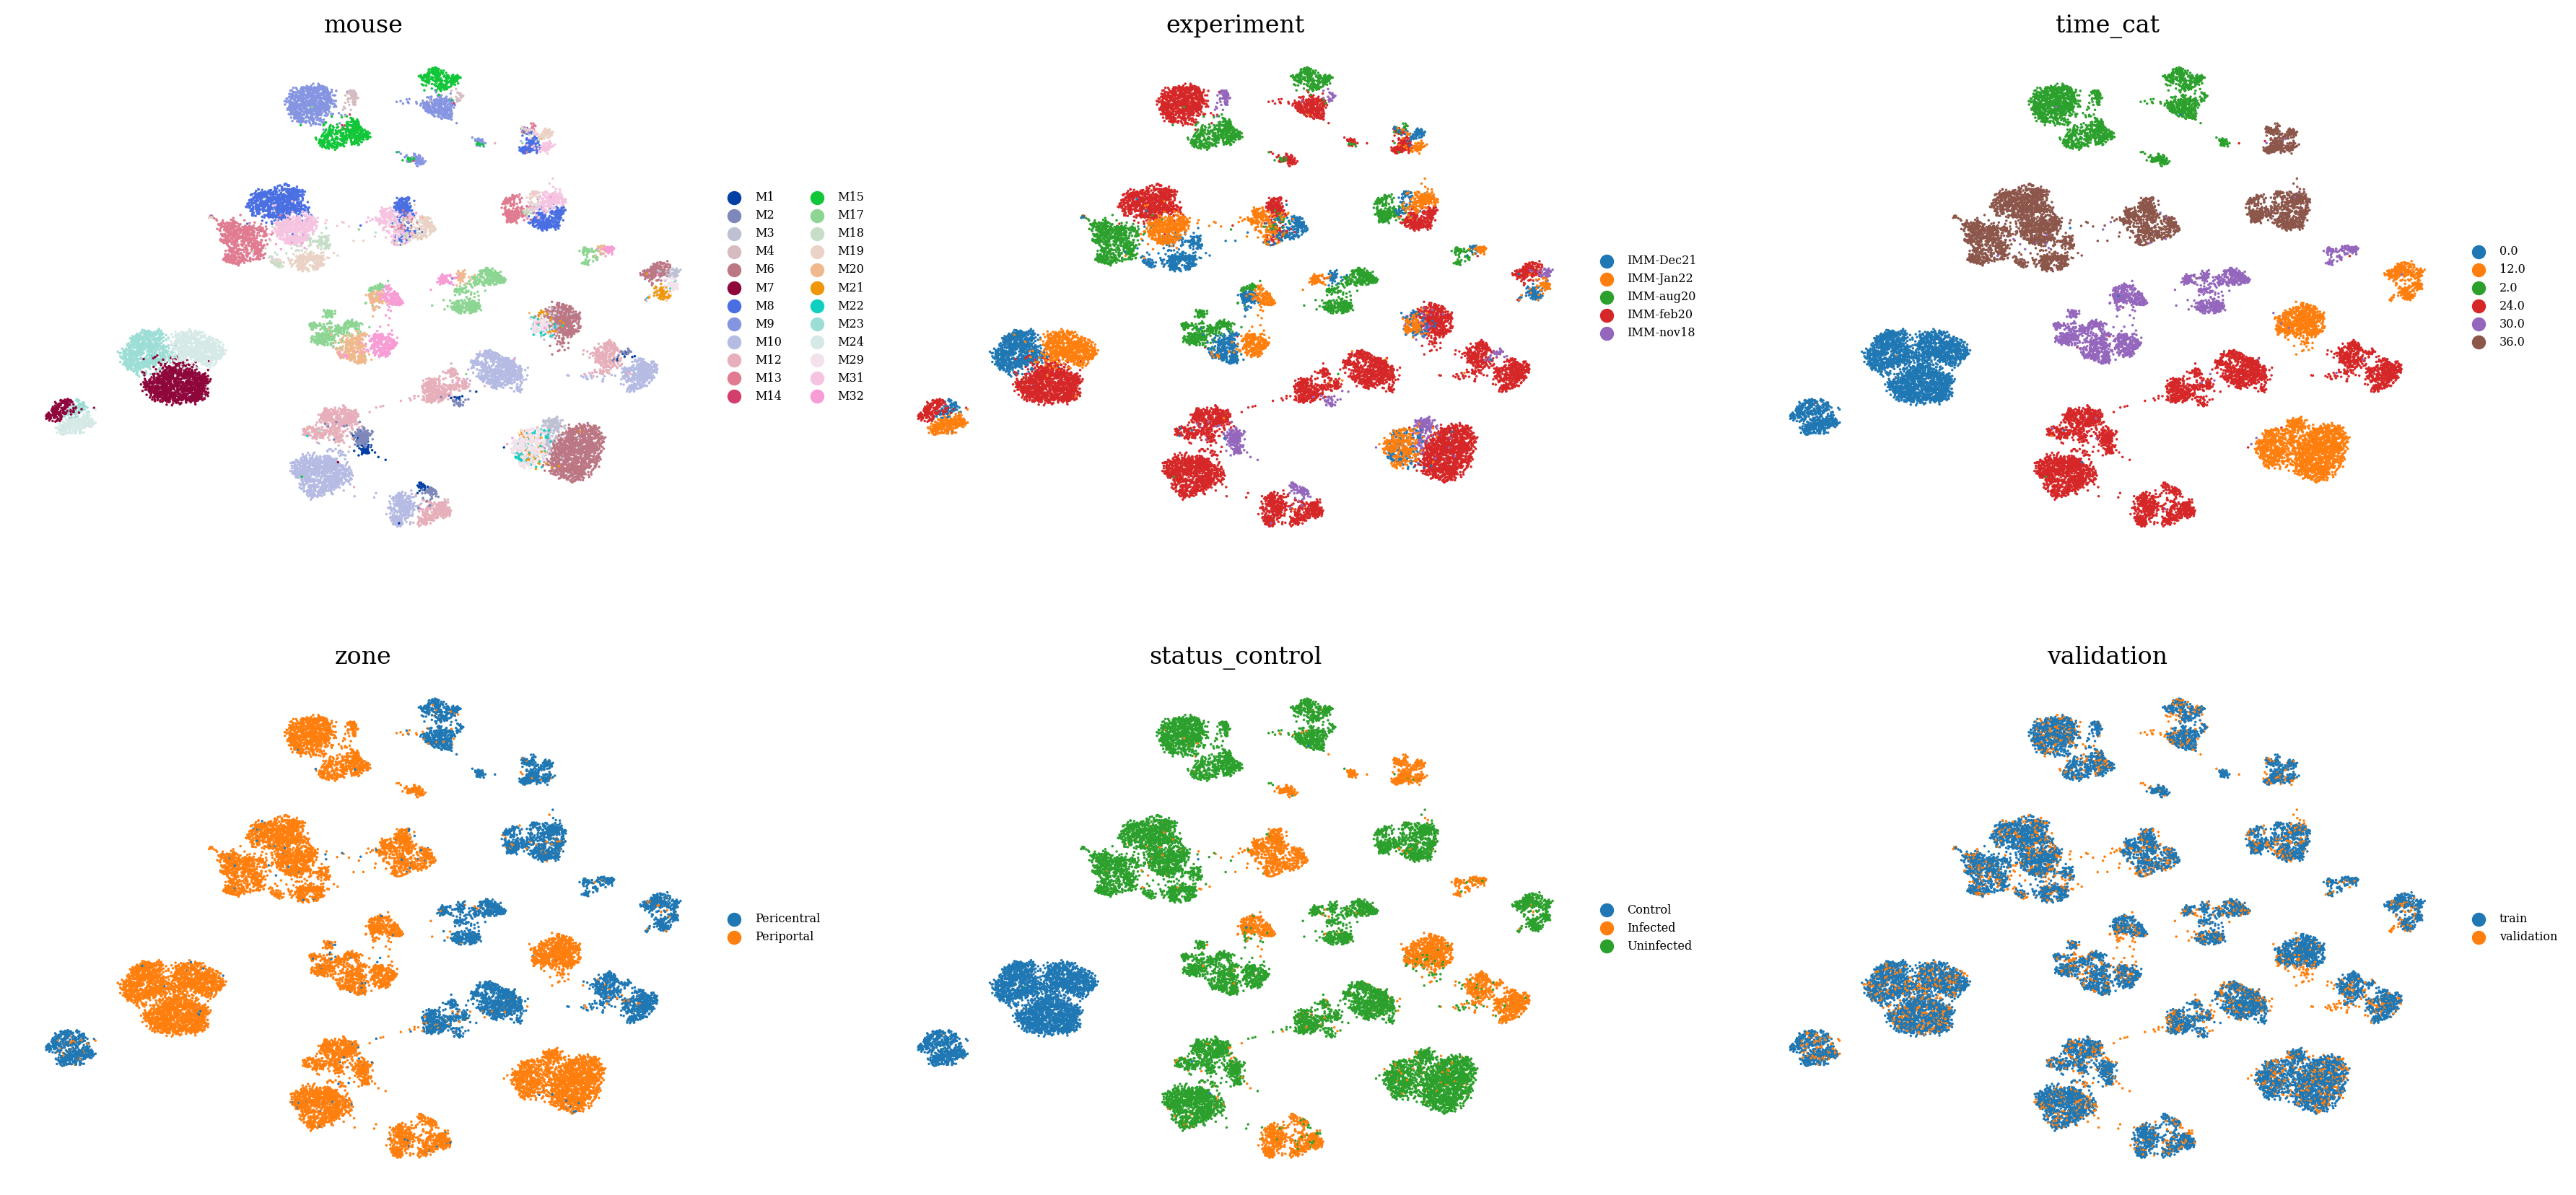

In [14]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

## Preds

In [15]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [16]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


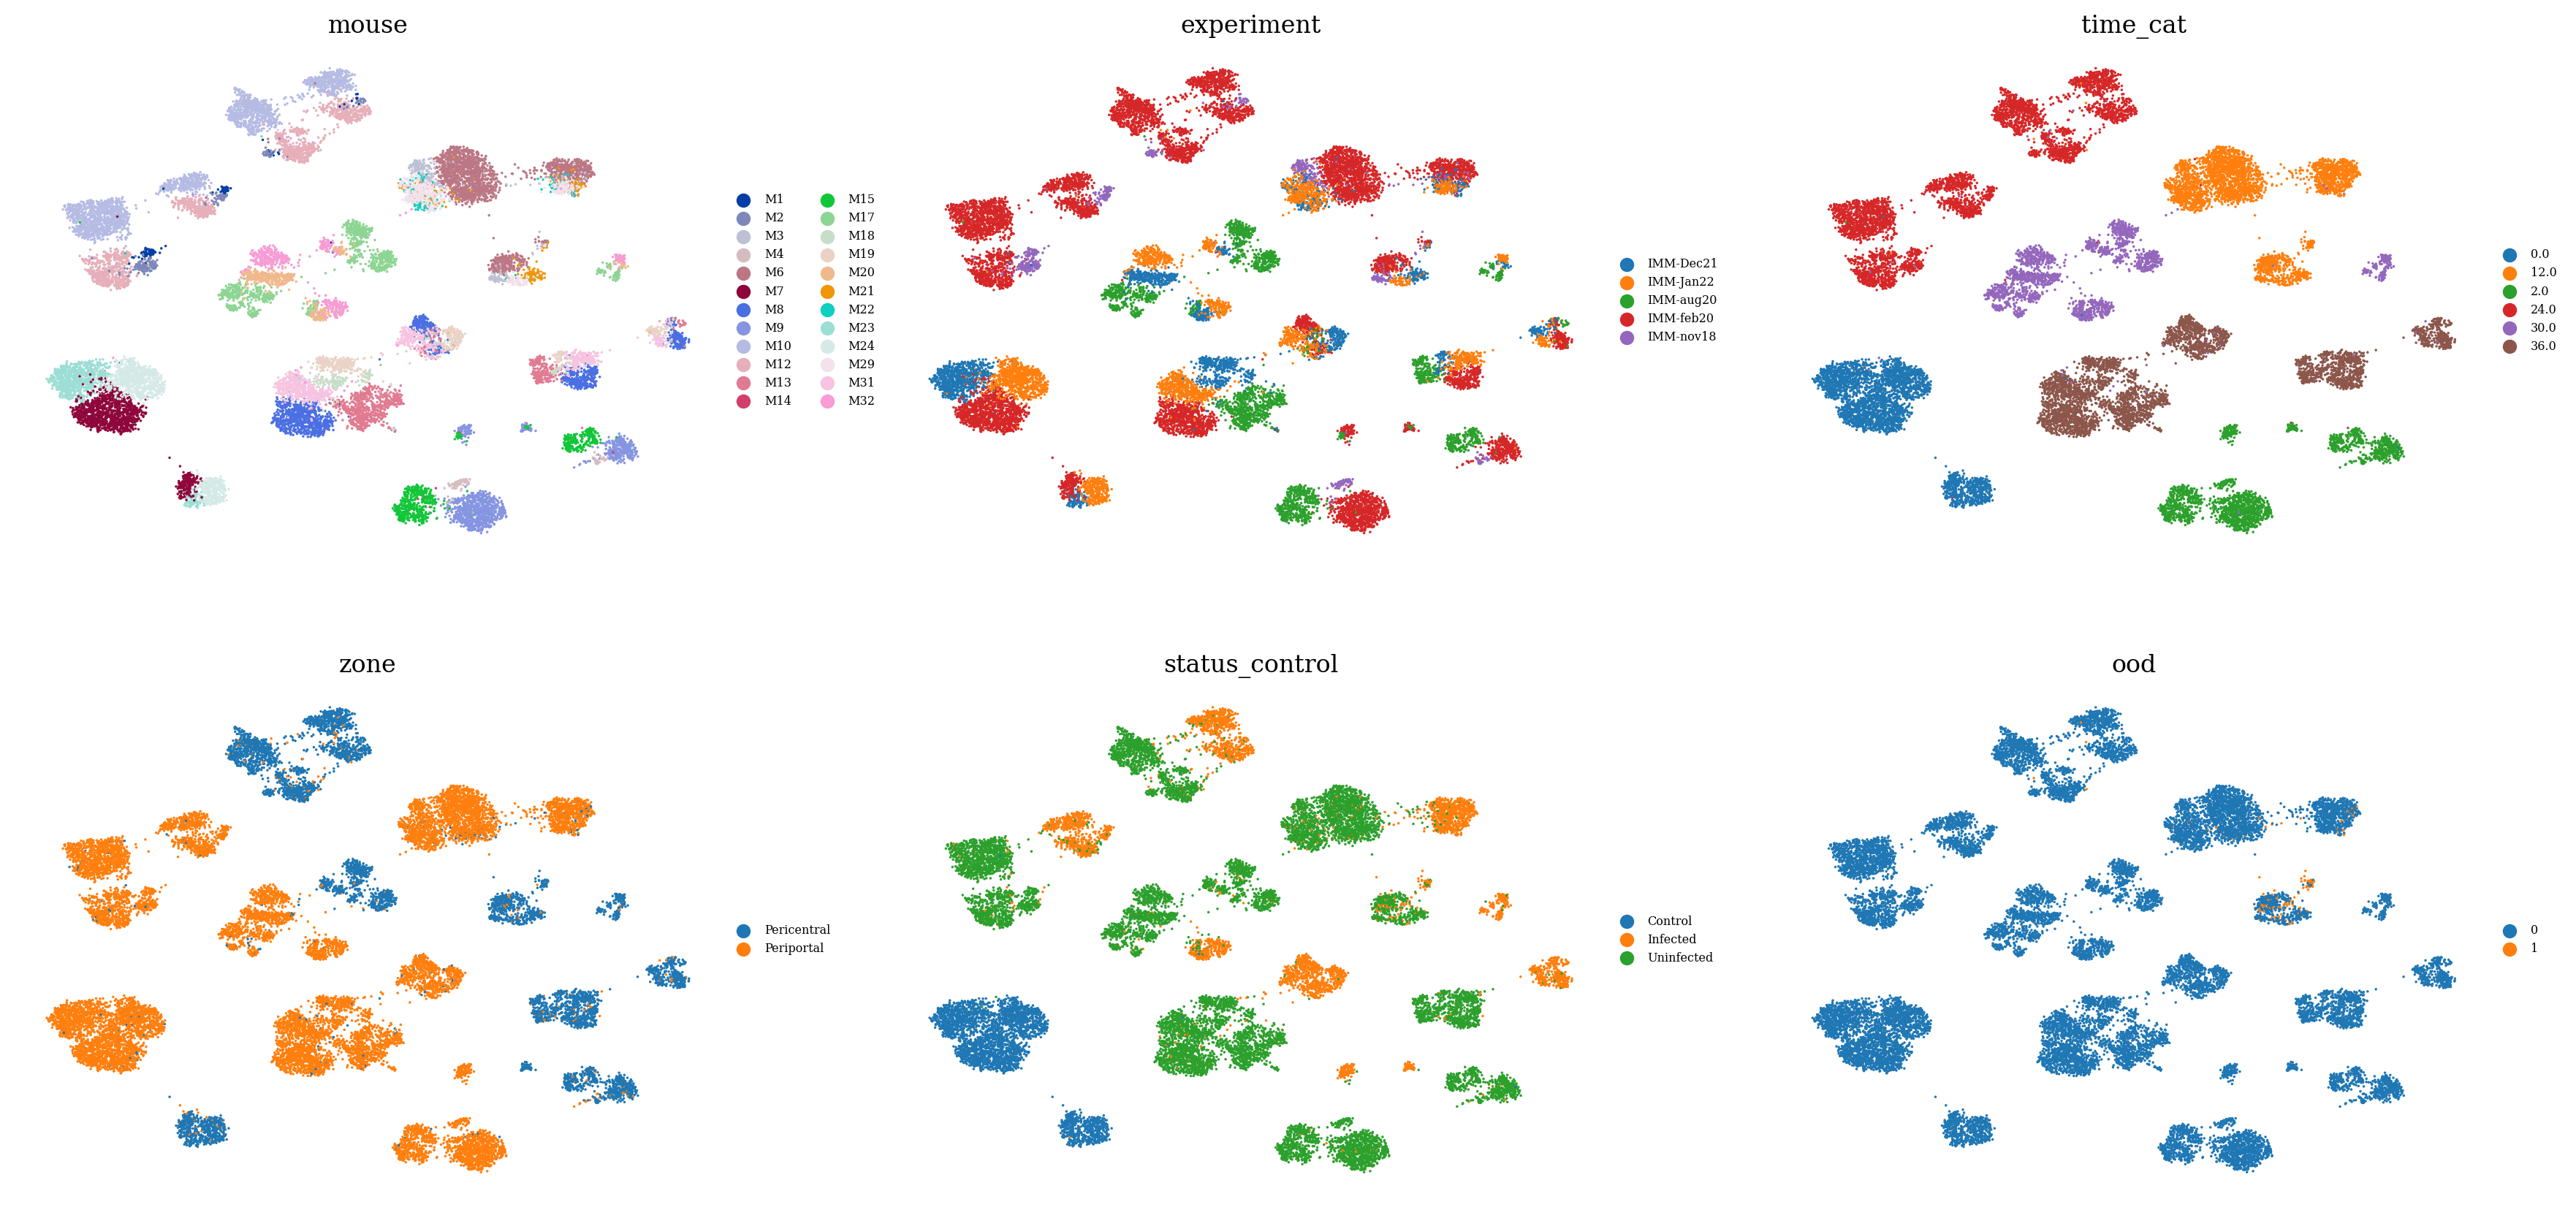

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "ood"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [18]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.454416627302787


F1 Weighted: 0.4533913832570295



{'accuracy': 0.3743016759776536,
 'precision_macro': 0.5,
 'recall_macro': 0.1871508379888268,
 'f1_score_macro': 0.27235772357723576,
 'precision_micro': 0.3743016759776536,
 'recall_micro': 0.3743016759776536,
 'f1_score_micro': 0.37430167597765357,
 'precision_weighted': 1.0,
 'recall_weighted': 0.3743016759776536,
 'f1_score_weighted': 0.5447154471544715,
 'confusion_matrix': array([[ 67, 112],
        [  0,   0]])}

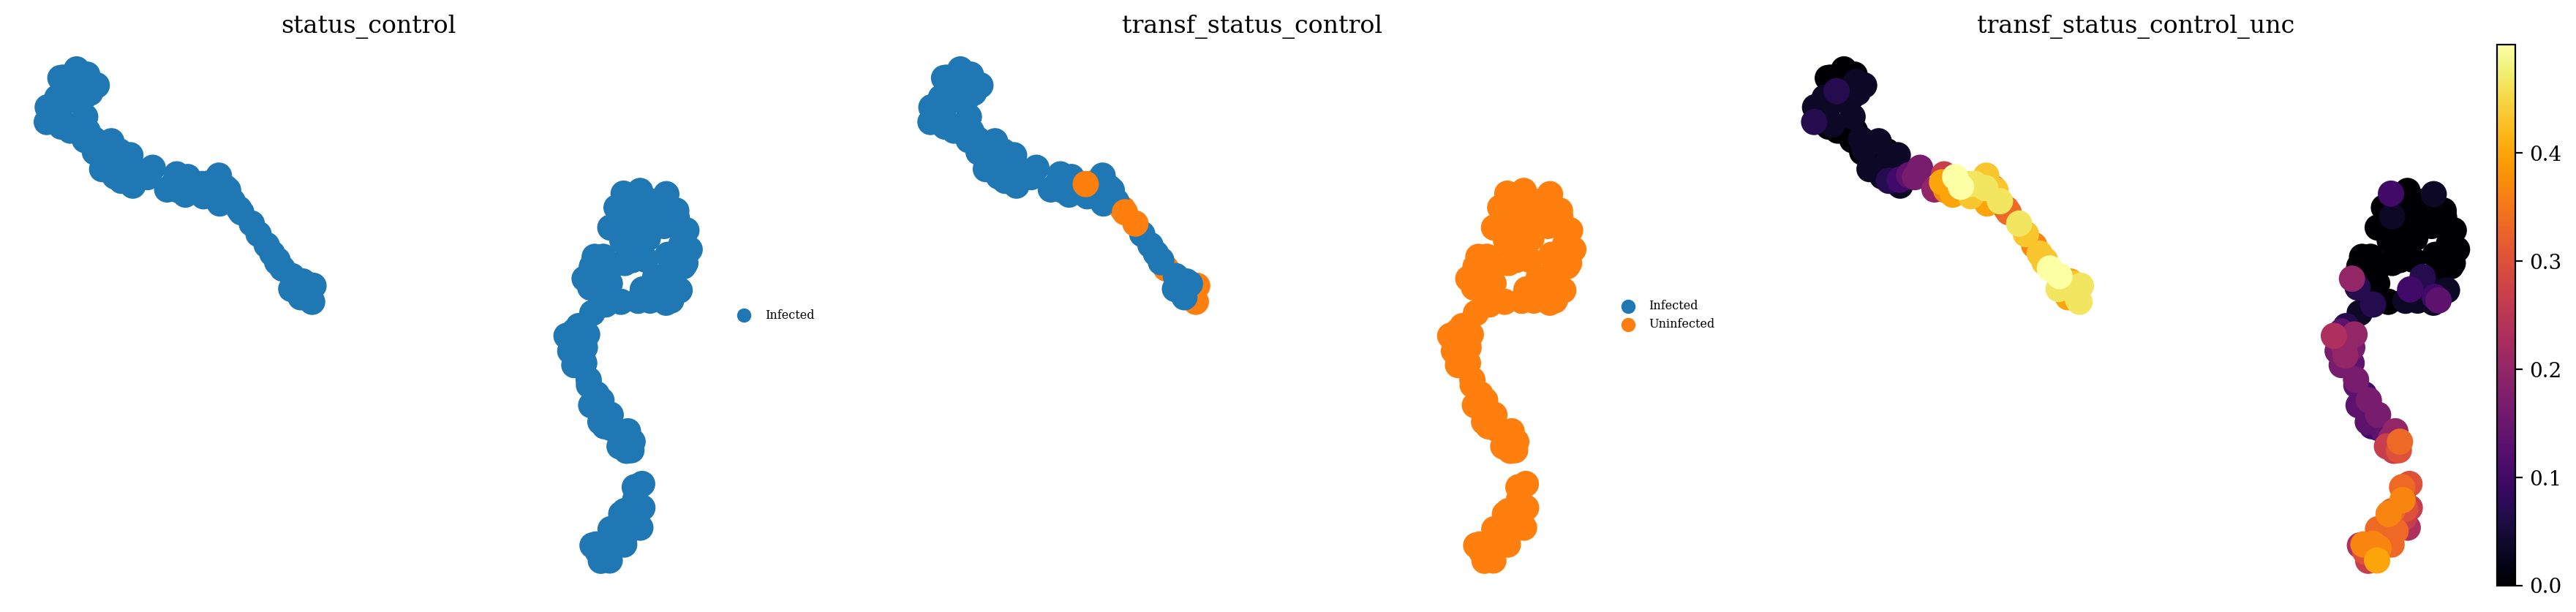

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [20]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata), obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood), obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.45777567837086025


F1 Weighted: 0.4578993236949998



{'accuracy': 0.30726256983240224,
 'precision_macro': 0.5,
 'recall_macro': 0.15363128491620112,
 'f1_score_macro': 0.23504273504273504,
 'precision_micro': 0.30726256983240224,
 'recall_micro': 0.30726256983240224,
 'f1_score_micro': 0.30726256983240224,
 'precision_weighted': 1.0,
 'recall_weighted': 0.30726256983240224,
 'f1_score_weighted': 0.4700854700854701,
 'confusion_matrix': array([[ 55, 124],
        [  0,   0]])}